In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
#cartopy pip install is broken on colab. do it the hard way
!apt-get install libproj-dev proj-bin proj-data
!apt-get install libgeos-dev

# shapely needs to be reinstalled to use the same geos install as cartopy (https://github.com/SciTools/cartopy/issues/871)
!pip uninstall -y shapely
!pip install --no-binary shapely shapely
!pip install cartopy

!pip install git+git://github.com/ResidentMario/geoplot.git
!pip install geopandas
!pip install pygeos

import pandas as pd
import geopandas
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import geoplot as gpl

Reading package lists... Done
Building dependency tree       
Reading state information... Done
proj-data is already the newest version (4.9.3-2).
proj-data set to manually installed.
The following NEW packages will be installed:
  libproj-dev proj-bin
0 upgraded, 2 newly installed, 0 to remove and 21 not upgraded.
Need to get 232 kB of archives.
After this operation, 1,220 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libproj-dev amd64 4.9.3-2 [199 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 proj-bin amd64 4.9.3-2 [32.3 kB]
Fetched 232 kB in 1s (371 kB/s)
Selecting previously unselected package libproj-dev:amd64.
(Reading database ... 144611 files and directories currently installed.)
Preparing to unpack .../libproj-dev_4.9.3-2_amd64.deb ...
Unpacking libproj-dev:amd64 (4.9.3-2) ...
Selecting previously unselected package proj-bin.
Preparing to unpack .../proj-bin_4.9.3-2_amd64.deb ...
Unpacking proj-bin (4.

/usr/local/lib/python3.6/dist-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.6.2-CAPI-1.10.2 4d2925d6) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Process all CSVs

In [11]:
import os
#!ls "/content/drive/My Drive/citadel_hack/Datathon Materials"

path='/content/drive/My Drive/citadel_hack/Datathon Materials' #might need to change that depending on what you have 
counties_path=[] 
census_path=[]
for file in os.scandir(path) :
  if file.name.endswith('.zip'):
    !unzip "$file.path" 
  elif 'Counties' in file .name:
    counties_path+=[file.path]
  elif file.name.endswith('.csv'):
    census_path+=[file.path]

call_311_path=[]
for i in os.scandir('/content/'): 
  if i.name.endswith('.csv'):
    call_311_path+=[i.path]

Archive:  /content/drive/My Drive/citadel_hack/Datathon Materials/311Calls_2018.zip
  inflating: 2018.csv                Archive:  /content/drive/My Drive/citadel_hack/Datathon Materials/311Calls_2017.zip
  inflating: 2017.csv                Archive:  /content/drive/My Drive/citadel_hack/Datathon Materials/311Calls_2016.zip
  inflating: 2016.csv                Archive:  /content/drive/My Drive/citadel_hack/Datathon Materials/311Calls_2015.zip
  inflating: 2015.csv                
Archive:  /content/drive/My Drive/citadel_hack/Datathon Materials/311Calls_2014.zip
  inflating: 2014.csv                
Archive:  /content/drive/My Drive/citadel_hack/Datathon Materials/311Calls_2013.zip
  inflating: 2013.csv                
Archive:  /content/drive/My Drive/citadel_hack/Datathon Materials/311Calls_2010.zip
  inflating: 2010.csv                
Archive:  /content/drive/My Drive/citadel_hack/Datathon Materials/311Calls_2012.zip
  inflating: 2012.csv                
Archive:  /content/drive/My

In [12]:
def join_tract_ids(df, tracts):
  '''Adds tract information to events in dataframe. Joins on `(State Plane)` columns, as they have less missing values.
  df: DataFrame created from a YYYY.csv 311 events file
  tracts: GeoDataFrame created from censustracts_newyork 
  source data can be found here https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
  give path to directory after unzipping to geopandas.read_file()
  '''
  df = df[~df['X Coordinate (State Plane)'].isna()]
  #Use state coordinates - conversion was not done for early years.
  gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df['X Coordinate (State Plane)'],df[ 'Y Coordinate (State Plane)']))
  gdf.crs = {'init': 'epsg:2263'}
  gdf = gdf.to_crs('EPSG:4269')

  #gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.Longitude,df.Latitude))
  #gdf = gdf.set_crs('EPSG:4269')

  df_with_tract = geopandas.sjoin(gdf, tracts, how='left', op='intersects' )

  #drop unmappable entries
  df_with_tract = df_with_tract[~df_with_tract['TRACTCE'].isna()]

  return df_with_tract

Make one dataframe for all years with total 311 call yearly sums per tract

In [13]:
tracts = geopandas.read_file("/content/drive/My Drive/citadel_hack/censustracts_newyork")
yearly_totals = {}
for path in sorted(call_311_path):
  #pd.crosstab(df['GEOID'], df['Complaint Type'])
  df=pd.read_csv(path)
  print(f'before: {df.shape}')
  df=join_tract_ids(df, tracts)
  print(f'after: {df.shape}')
  year = path.rstrip('.csv').split('/')[-1]
  per_id_total_counts = df.groupby('GEOID')['Unique Key'].count()
  yearly_totals[year] = per_id_total_counts

df = pd.DataFrame.from_dict(yearly_totals)
df = df.fillna(0)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8,17,31,32,33,34,35,36,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


before: (507953, 41)


/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


after: (448263, 52)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


before: (490400, 41)


/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


KeyboardInterrupt: ignored

## Before attempting clustering - check for overall uniformity 
- don't want general differences between the years that confound results

In [14]:
#sns.displot(penguins, x="flipper_length_mm", hue="species")
plt.figure(figsize=(8,5))
sns.kdeplot(data=df.melt(), x='value', hue='variable', cut = 0)
plt.title('Large differences in incidents per tract distribution over the years.')
plt.xlim(0,500)

KeyboardInterrupt: ignored

<Figure size 576x360 with 0 Axes>

In [ ]:
#number of observed wards constant over the years. Probably no representation bias.
(df !=0).sum(axis=0)

In [ ]:
df.sum(axis=0).plot()
plt.title('Number of reports goes up rapidly after 2013.')

In [ ]:
#stupid rejoin for plotting because geographic borders of tracts are lost after the processing
tracts_per_year = tracts.set_index('GEOID').join(df, how='inner')

fig, axs = plt.subplots(1,3, figsize=(20,5))
xlim = (-74.1,-73.8)
ylim = (40.6, 40.9)

ax= axs[0]
geoplot.choropleth(tracts_per_year, hue = tracts_per_year['2010'],linewidth=0.001, legend=True, ax = ax)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title('2010')


ax= axs[1]
geoplot.choropleth(tracts_per_year, hue = tracts_per_year['2014'],linewidth=0.001, legend=True, ax = ax)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title('2014')

ax= axs[2]
geoplot.choropleth(tracts_per_year, hue = tracts_per_year['2018'],linewidth=0.001, legend=True, ax = ax)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title('2018')

In [ ]:
differences = df.pct_change(axis=1)[df.columns[1:]]

In [ ]:
#laplace smoothed
differences = df[['2010','2013', '2016', '2018']].replace(0,1).pct_change(axis=1)#[df.columns[1:]]
differences=  differences[differences.columns[1:]]

In [ ]:
differences = differences.clip(lower=-1,upper=1)

In [ ]:
tracts_per_year = tracts.set_index('GEOID').join(differences, how='inner')

fig, axs = plt.subplots(1,3, figsize=(20,5))
xlim = (-74.1,-73.8)
ylim = (40.6, 40.9)

ax= axs[0]
geoplot.choropleth(tracts_per_year, hue = tracts_per_year['2013'],linewidth=0.001, legend=True, ax = ax)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title('2013')


ax= axs[1]
geoplot.choropleth(tracts_per_year, hue = tracts_per_year['2016'],linewidth=0.001, legend=True, ax = ax)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title('2016')

ax= axs[2]
geoplot.choropleth(tracts_per_year, hue = tracts_per_year['2018'],linewidth=0.001, legend=True, ax = ax)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title('2018')

Plot shows differences in calls between 2010-2013, 2013-2016 and 2016-2018. I believe 2013-2016 is confounded by the overall increase. Need to find smart way to normalize everyting.

In [ ]:
#melted df of all year-category counts per tract

all_dfs = []
for path in sorted(call_311_path):
  df=pd.read_csv(path)
  df=join_tract_ids(df, tracts)
  year = path.rstrip('.csv').split('/')[-1]
  counts = df.groupby('GEOID')['Complaint Type'].value_counts()
  counts = counts.unstack(fill_value=0)
  counts['Year'] = year
  counts = counts.reset_index().melt(id_vars=['GEOID', 'Year'], value_name='count')
  all_dfs.append(counts)

df = pd.concat(all_dfs)
df = df[~(df['count'] ==0)]

In [ ]:
df.to_csv('/content/drive/My Drive/citadel_hack/complaints_per_year.csv')

# Analyze cleaned 311 frequency data

There are three different dimensions: Year, Category, Tract - How to normalize?
- normalize each year by its total


In [15]:
df = pd.read_csv('/content/drive/My Drive/citadel_hack/CitadelDatathon2020/data/complaints_per_year.csv')
labels =  pd.read_csv('/content/drive/My Drive/citadel_hack/CitadelDatathon2020/data/gentrification_labels_UDP_2019.csv')
relabel_df = pd.read_csv('/content/drive/My Drive/citadel_hack/CitadelDatathon2020/data/complaint_categorization.csv')

In [16]:
df = df.merge(relabel_df, on='Complaint Type',how='left')
labels = labels.rename({'geoid': 'GEOID', 'Type_1.19': 'Gentrification Status'}, axis=1)
df = df.merge(labels, on='GEOID',how='left')

In [17]:
year = 2018
df_year = df.loc[df['Year']==year]
total_count_df = pd.DataFrame(df_year.groupby('GEOID').sum()['count']).merge(labels, on='GEOID',how='left')
total_count_df = total_count_df.rename({'count':'Number of calls'}, axis=1)

In [18]:
#census total ethnicity stats
census_df = pd.read_csv(f'/content/drive/My Drive/citadel_hack/Datathon Materials/Census{year}.csv')
column_names={'B01001_001E':'Population','B19013_001E':'mid_Income','B25077_001E':'mid_Home_$$','B03002_003E':'Nbr_Caucasians',
 'B03002_004E':'Nbr_Af_Americans','B02001_004E':'Nbr_Ind_Alaskans','B03002_006E':'Nbr_Asians','B03002_007E':'Nbr_Hawaiian_Pac_Islands',
 'B03002_008E':'Nbr_others','B03002_009E':'nbr_mult_race','B03002_012E':'Nbr_Latinos'}
census_df.rename(columns=column_names,inplace=True)
filtered = census_df[[x for x in census_df.columns if 'Nbr_' in x]].sum(axis=0)#/census_df[[x for x in census_df.columns if 'Nbr_' in x]].sum()
filtered/filtered.sum()

Nbr_Caucasians              0.476129
Nbr_Af_Americans            0.159089
Nbr_Ind_Alaskans            0.003295
Nbr_Asians                  0.109142
Nbr_Hawaiian_Pac_Islands    0.000278
Nbr_others                  0.006350
Nbr_Latinos                 0.245718
dtype: float64

In [19]:
census_df = pd.read_csv(f'/content/drive/My Drive/citadel_hack/Datathon Materials/Census{year}.csv', usecols=['geoid', 'B01001_001E'])
census_df = census_df.rename({'B01001_001E':'Population', 'geoid': 'GEOID'}, axis=1)

In [20]:
total_count_df = total_count_df.merge(census_df,how='left', on='GEOID') #add populuation info

total_count_df = total_count_df.loc[~ (total_count_df['Population'] ==0)] #drop 0 population tracts

total_count_df['normalized counts'] = total_count_df['Number of calls']/total_count_df['Population'] #normalize

In [21]:
#clip outliers - or drop them? only like 30 wards, not more
total_count_df['normalized counts'] = total_count_df['normalized counts'].clip(upper= total_count_df['normalized counts'].quantile(0.99))

In [22]:
#total_count_df.sort_values('normalized counts', ascending=False).head(30)
#total_count_df['normalized counts'].clip()

Text(0.5, 1.0, 'KDE')

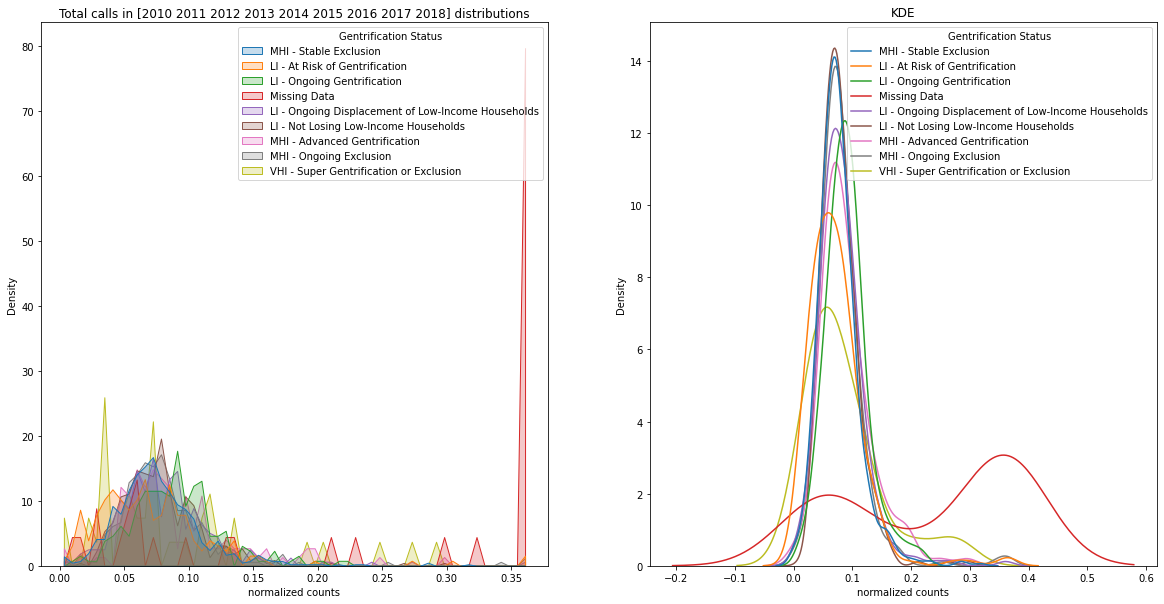

In [23]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.histplot(data=total_count_df, x='normalized counts', hue='Gentrification Status', kde=False, element="poly", common_norm=False, fill=True, stat='density')
plt.title(f"Total calls in {df['Year'].unique()} distributions")
plt.subplot(1,2,2)
sns.kdeplot(data=total_count_df, x='normalized counts', hue='Gentrification Status', common_norm=False)
plt.title('KDE')

Missing data is weird. drop. I assume this is parks/recreational areas or whatever where nobody lives but people call and complain

In [24]:
total_count_df = total_count_df.loc[~(total_count_df['Gentrification Status']== 'Missing Data')]

Text(0.5, 1.0, 'KDE')

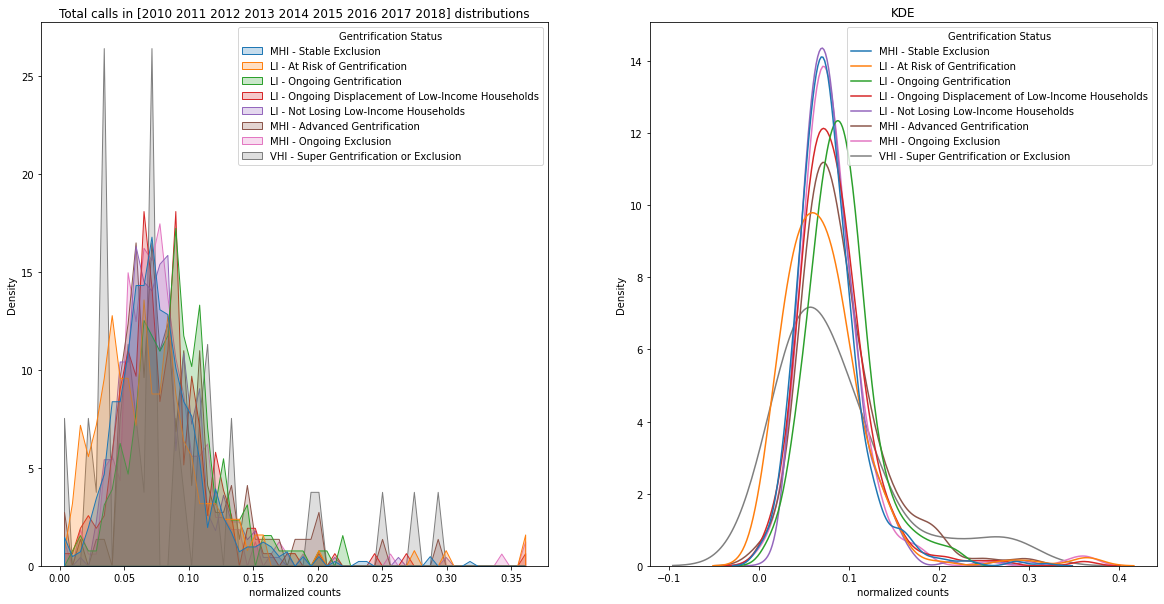

In [25]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.histplot(data=total_count_df, x='normalized counts', hue='Gentrification Status', kde=False, element="poly", common_norm=False, fill=True, stat='density')
plt.title(f"Total calls in {df['Year'].unique()} distributions")
plt.subplot(1,2,2)
sns.kdeplot(data=total_count_df, x='normalized counts', hue='Gentrification Status', common_norm=False)
plt.title('KDE')

# Investigate recategorized calls

## Clean up categories

In [26]:
count_missing = df.groupby(['GEOID','Complaint Category', 'Year'])['count'].sum().unstack().unstack().reset_index()
missingcount = count_missing.drop('GEOID', axis=1).isnull().sum().sum()
missing_ratio = missingcount/count_missing.drop('GEOID', axis=1).size

print('missing values ratio relabeled')
print(missing_ratio)

count_missing = df.groupby(['GEOID','Complaint Type', 'Year'])['count'].sum().unstack().unstack().reset_index()
missingcount = count_missing.drop('GEOID', axis=1).isnull().sum().sum()
missing_ratio = missingcount/count_missing.drop('GEOID', axis=1).size

print('missing values ratio original')
print(missing_ratio)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3884: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


missing values ratio relabeled
0.3394020168010067
missing values ratio original
0.8230630055342699


In [27]:
df['Complaint Category'].unique().shape

(24,)

In [28]:
df.groupby(['Complaint Category', 'Year'])['count'].sum().unstack()

Year,2010,2011,2012,2013,2014,2015,2016,2017,2018
Complaint Category,,,,,,,,,
Animals,1005.0,1015.0,1033.0,1022.0,3296.0,3577.0,3589.0,3429.0,3226.0
Building,34240.0,35203.0,29484.0,29056.0,49648.0,54290.0,50962.0,50417.0,54383.0
Business,8041.0,7898.0,8342.0,7871.0,8442.0,9567.0,9982.0,10902.0,11949.0
Cleanliness,19.0,20.0,19.0,22.0,32.0,28.0,14.0,20.0,15.0
Construction,44715.0,41559.0,37796.0,36833.0,13770.0,10275.0,9013.0,8955.0,10001.0
Fire,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0
Health,6241.0,4158.0,3979.0,4142.0,4269.0,4626.0,7012.0,5916.0,5950.0
Hygiene,12247.0,11349.0,11263.0,11499.0,28023.0,35665.0,36004.0,37855.0,40282.0
Infrastructure,84633.0,78307.0,72922.0,77431.0,54635.0,26541.0,27000.0,22772.0,22589.0


In [29]:
categories_to_drop = ['Request', 'Fire', 'Cleanliness', 'Parking']
df = df.loc[~df['Complaint Category'].isin(categories_to_drop)]

## Sum up and normalize

In [30]:
df = df.groupby(['GEOID', 'Year', 'Complaint Category'])['count'].sum().unstack().reset_index()
df = df.melt(id_vars=['GEOID', 'Year']).dropna()

In [31]:
 df = df.merge(labels, on='GEOID',how='left')
 df = df.merge(census_df,how='left', on='GEOID') #add populuation info

In [32]:
df = df.loc[~ (df['Gentrification Status'] =='Missing Data')]
df = df.loc[~ (df['Population'] ==0)] #drop 0 population tracts

df['normalized count'] = df['value']/df['Population'] #normalize

In [33]:
df.groupby(['GEOID', 'Complaint Category', 'Year'])['value'].sum().unstack()

Year                            2010  2011  2012  2013  ...  2015  2016  2017  2018
GEOID       Complaint Category                          ...                        
36005000100 Building             NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   4.0
            Business             1.0   2.0   NaN   1.0  ...   NaN   2.0   2.0   1.0
            Construction         NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   1.0
            Health               NaN   NaN   NaN   NaN  ...   NaN   1.0   1.0   NaN
            Infrastructure       NaN   1.0   NaN   NaN  ...   1.0   1.0   2.0   NaN
...                              ...   ...   ...   ...  ...   ...   ...   ...   ...
36119002900 Services             NaN   NaN   1.0   NaN  ...   NaN   NaN   NaN   NaN
            Street Condition     1.0   NaN   2.0   NaN  ...   NaN   NaN   NaN   1.0
            Waste                NaN   NaN   NaN   NaN  ...   NaN   NaN   1.0   1.0
36119005500 Noise                NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN
            Street Condition     1.0   NaN   NaN   NaN  ...   2.0   NaN   NaN   1.0

[39749 rows x 9 columns]

In [34]:
plot_df = df.loc[df['Complaint Category'] =='Building']#[['GEOID', 'normalized count', 'Gentrification Status']]
#plot_df  = plot_df.loc[df['Year'] ==2018]

In [35]:
plot_df

,GEOID,Year,Complaint Category,value,Gentrification Status,Population,normalized count
9748,36005000100,2018,Building,4.0,MHI - Stable Exclusion,7080.0,0.000565
9749,36005000200,2010,Building,19.0,MHI - Stable Exclusion,4542.0,0.004183
9750,36005000200,2011,Building,8.0,MHI - Stable Exclusion,4542.0,0.001761
9751,36005000200,2012,Building,22.0,MHI - Stable Exclusion,4542.0,0.004844
9752,36005000200,2013,Building,11.0,MHI - Stable Exclusion,4542.0,0.002422
...,...,...,...,...,...,...,...
28333,36085032300,2018,Building,29.0,MHI - Stable Exclusion,1138.0,0.025483
28334,36119001503,2012,Building,1.0,MHI - Stable Exclusion,2842.0,0.000352
28335,36119001503,2013,Building,1.0,MHI - Stable Exclusion,2842.0,0.000352
28336,36119001503,2015,Building,1.0,MHI - Stable Exclusion,2842.0,0.000352


## Means over the years

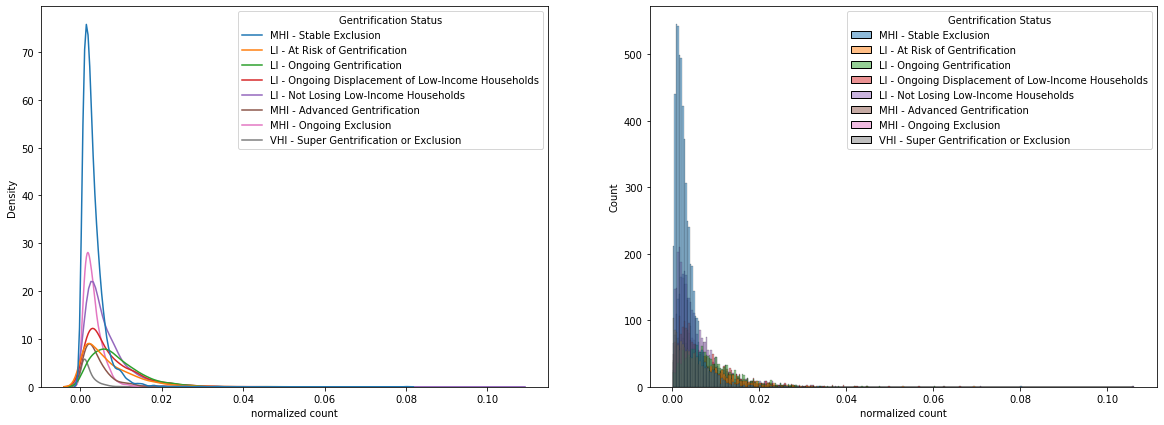

In [36]:
#sns.histplot(plot_df, x='normalized count', hue='Gentrification Status', element="poly", ax=ax)
#sns.displot(data=penguins, x="flipper_length_mm", hue="species", col="sex", kind="kde")
#sns.displot(plot_df, x='normalized count', hue='Gentrification Status', kind='kde')
plt.figure(figsize=(20,7))
plt.title('Buiding complaints in 2018')
plt.subplot(1,2,1)
sns.kdeplot(data=plot_df, x='normalized count', hue='Gentrification Status')
plt.subplot(1,2,2)
sns.histplot(data=plot_df, x='normalized count', hue='Gentrification Status')

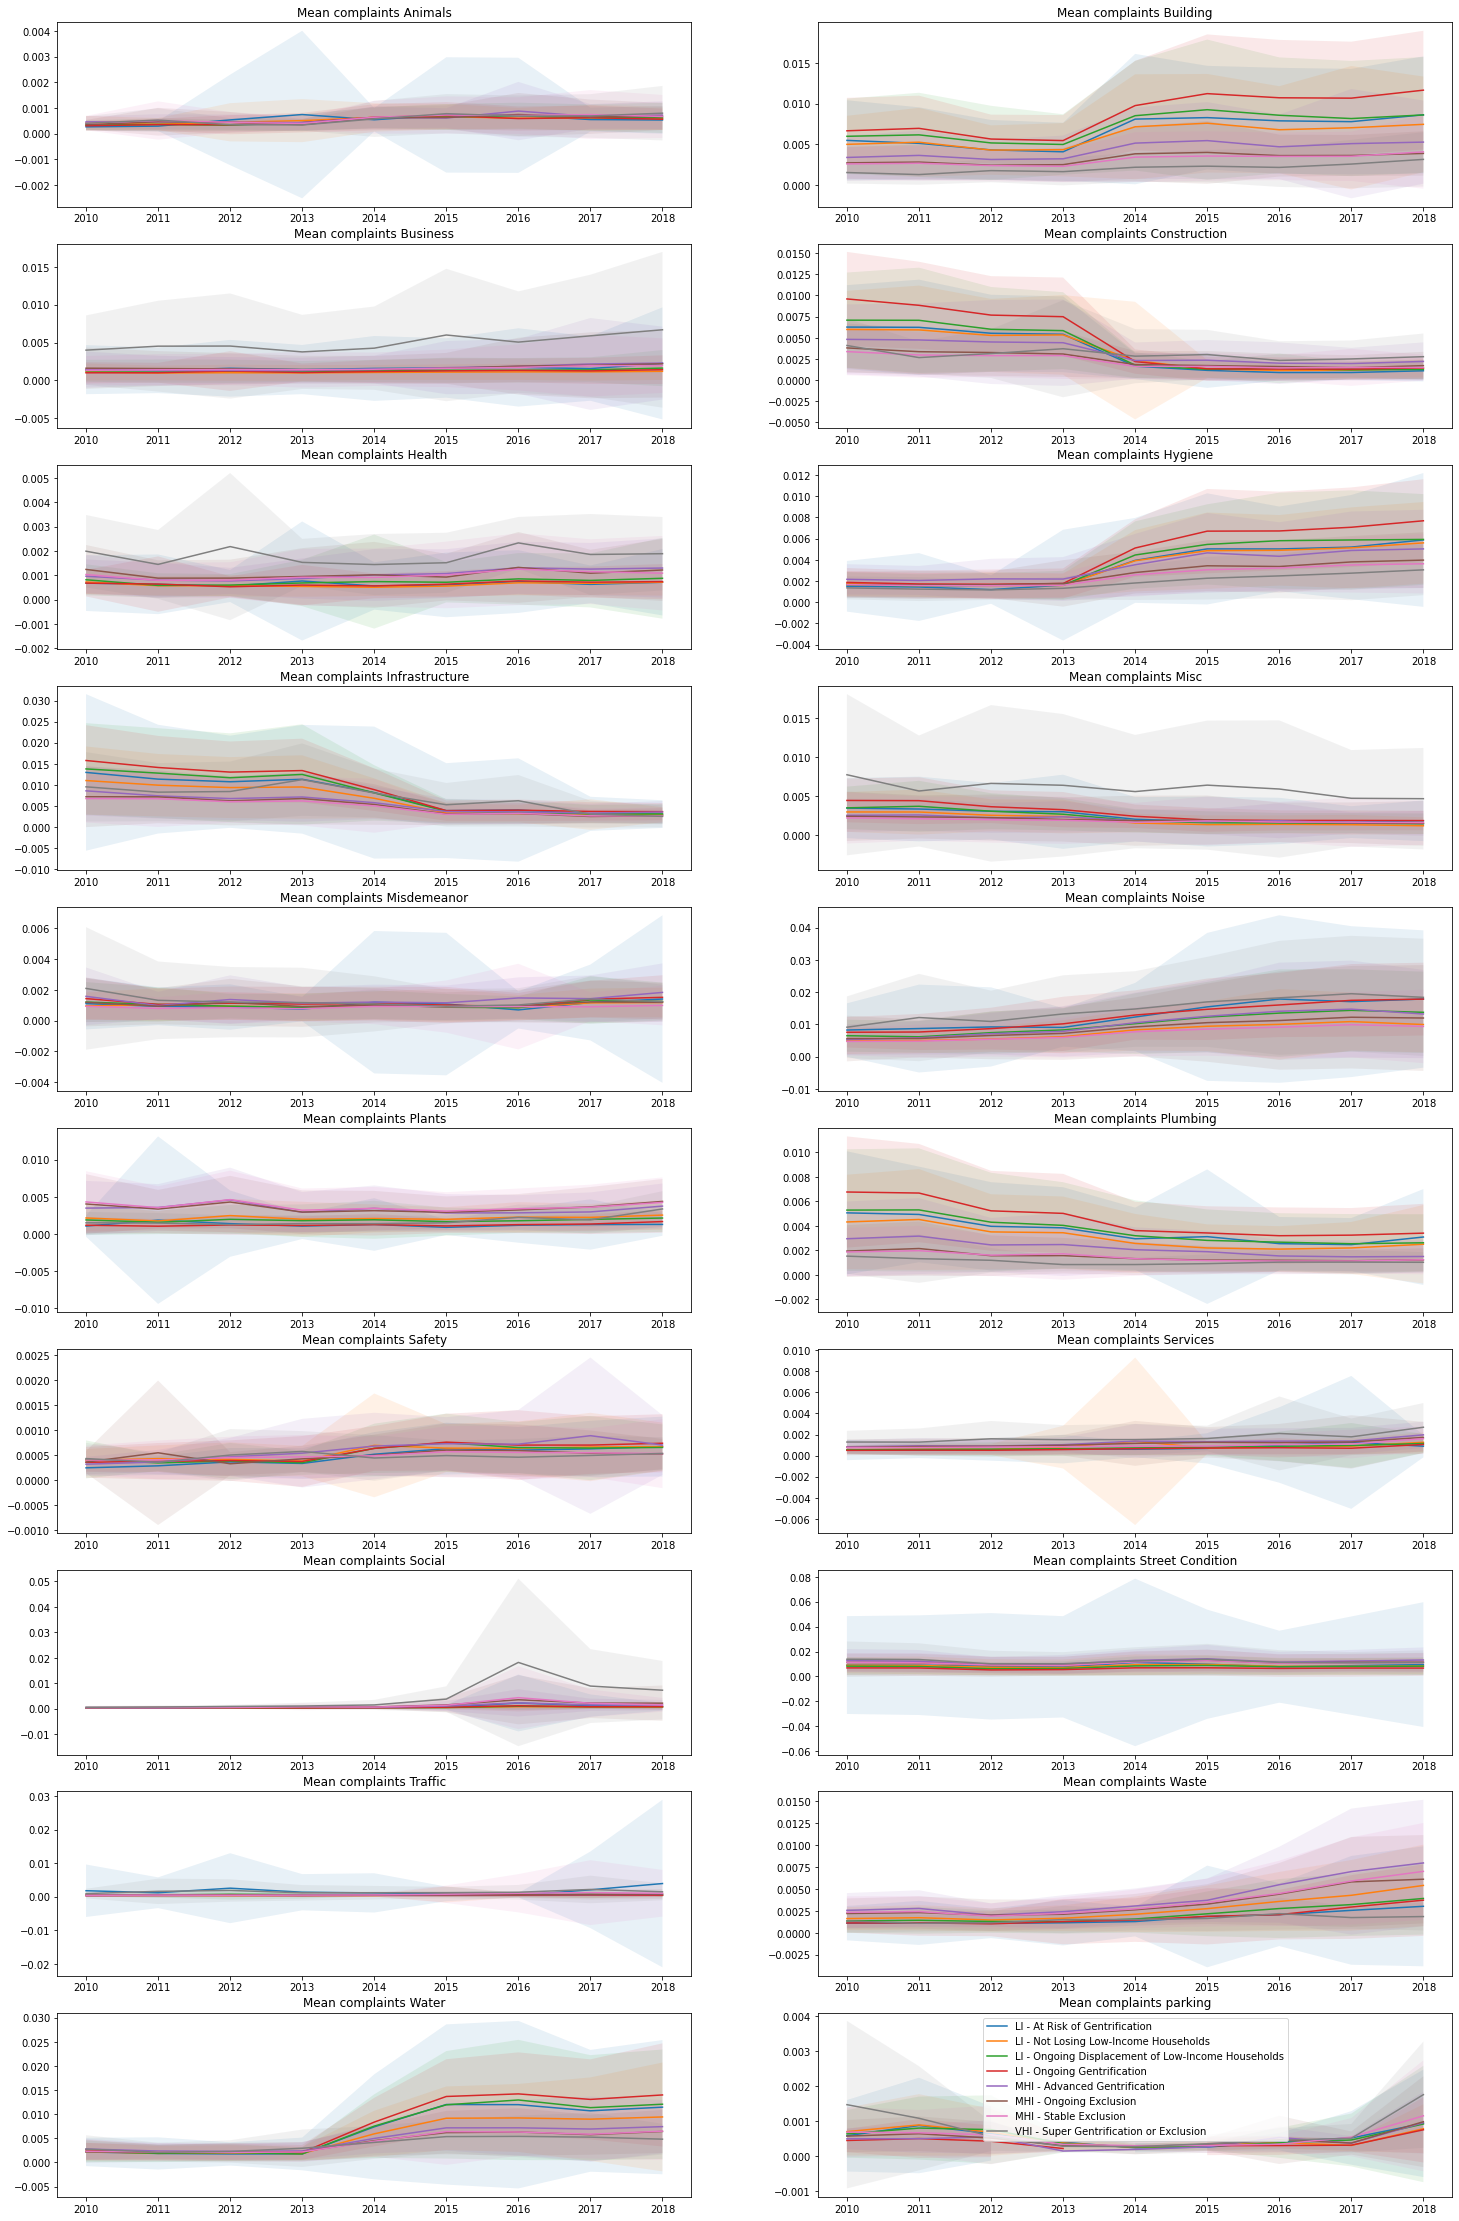

In [37]:
#pd.set_option('display.max_rows', 100)
fig, axs = plt.subplots(10,2, figsize = (25,40))

for idx, category in enumerate(df['Complaint Category'].unique()):
  ax = axs.flat[idx]

  plot_df = df.loc[df['Complaint Category'] ==category]#[['GEOID', 'normalized count', 'Gentrification Status']]
  agg_df = plot_df.groupby(['Gentrification Status', 'Year'])['normalized count'].agg(minimum='min', maximum='max', mean='mean', std='std')

  mean = agg_df['mean'].unstack().T
  std =  agg_df['std'].unstack().T

  for cat in mean.columns:
      ax.plot(mean.index, mean[cat], label=cat)
      ax.fill_between(mean.index, mean[cat] - std[cat], mean[cat] + std[cat], alpha=0.1)

  ax.set_title(f'Mean complaints {category}')

ax.legend()

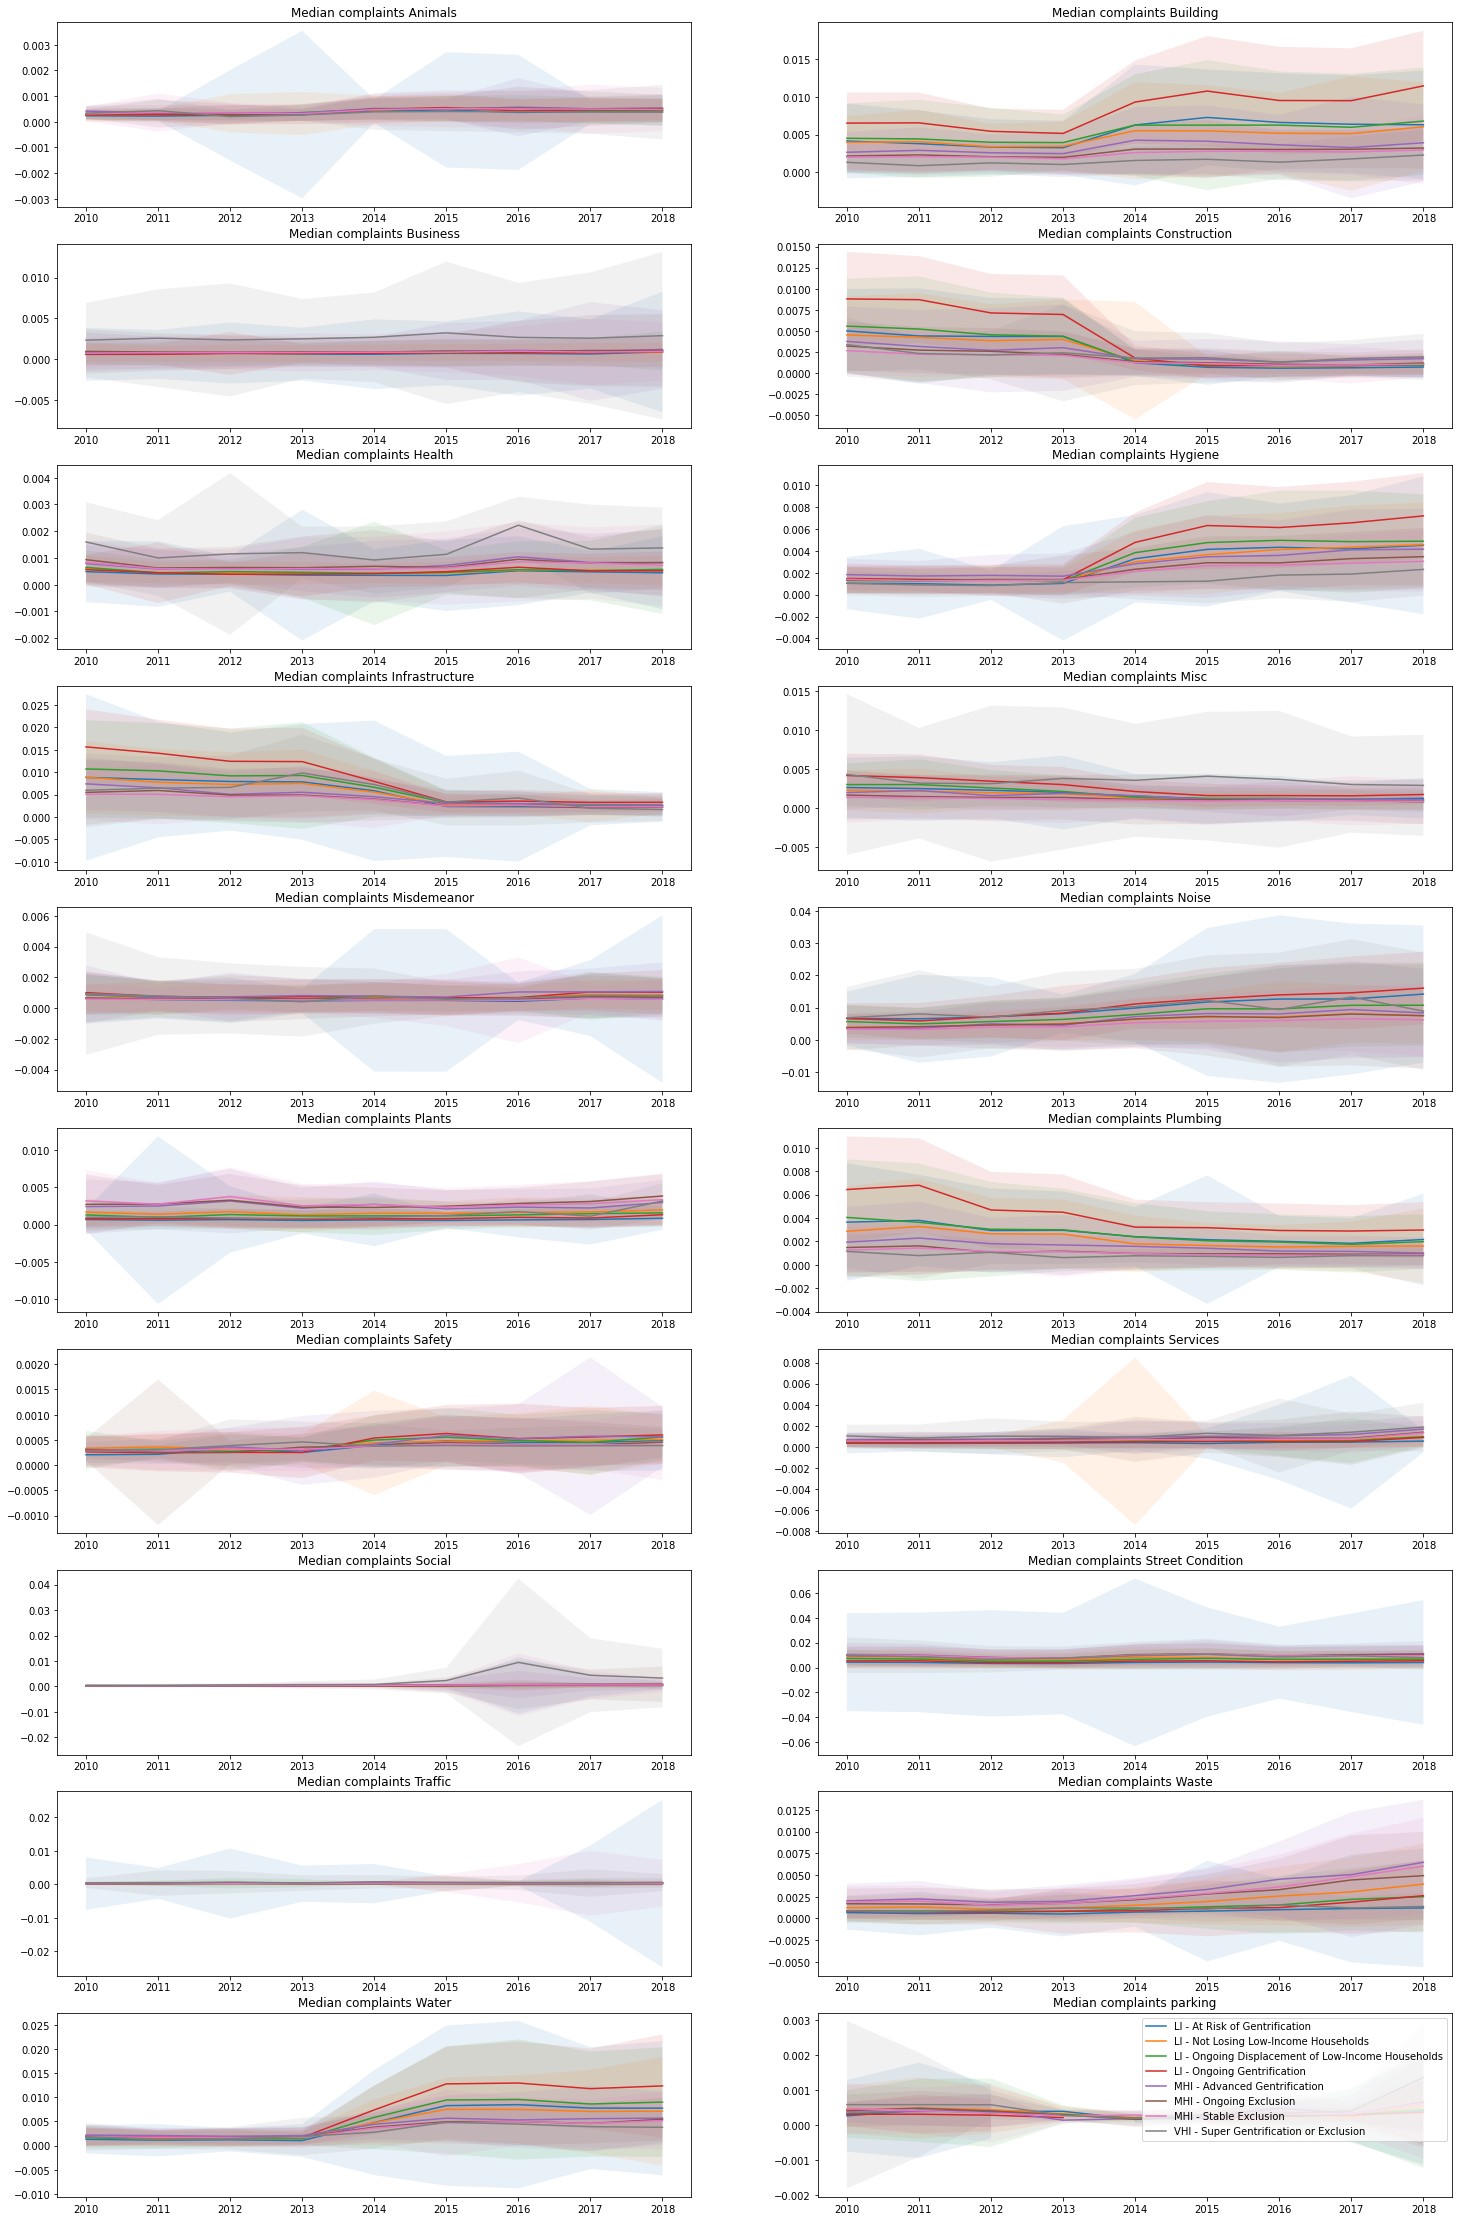

In [38]:
#pd.set_option('display.max_rows', 100)
fig, axs = plt.subplots(10,2, figsize = (25,40))

for idx, category in enumerate(df['Complaint Category'].unique()):
  ax = axs.flat[idx]

  plot_df = df.loc[df['Complaint Category'] ==category]#[['GEOID', 'normalized count', 'Gentrification Status']]
  agg_df = plot_df.groupby(['Gentrification Status', 'Year'])['normalized count'].agg(minimum='min', maximum='max', mean='median', std='std')

  mean = agg_df['mean'].unstack().T
  std =  agg_df['std'].unstack().T

  for cat in mean.columns:
      ax.plot(mean.index, mean[cat], label=cat)
      ax.fill_between(mean.index, mean[cat] - std[cat], mean[cat] + std[cat], alpha=0.1)

  ax.set_title(f'Median complaints {category}')

ax.legend()

## Predictive power

### Static values per year

In [39]:
from sklearn.feature_selection import mutual_info_classif



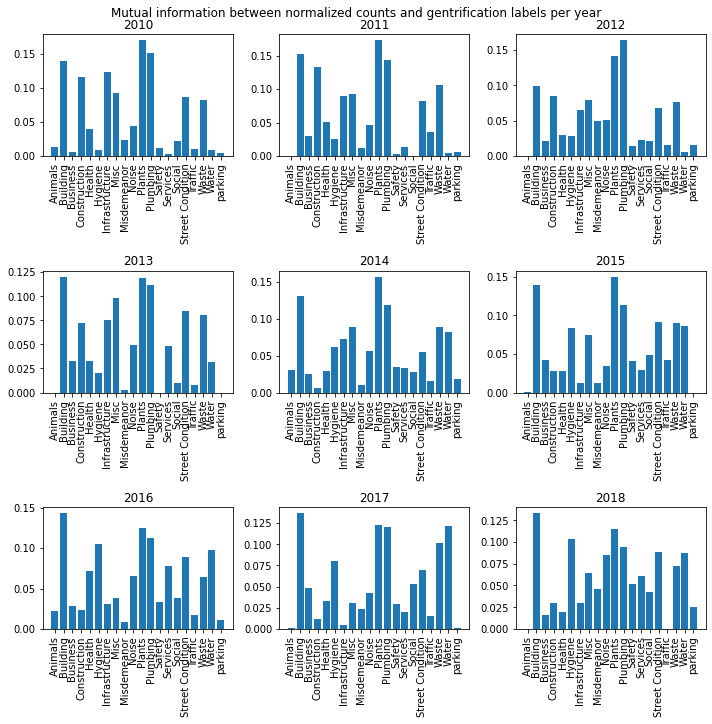

In [40]:
plt.figure(figsize=(10,10))

for idx, year in enumerate([2010,2011,2012,2013,2014,2015,2016,2017,2018]):

  plt.subplot(3,3,idx+1)
  feature_df = df.loc[df['Year'] ==year]#.pivot_table(columns='Complaint Category', rows='GEOID')
  feature_df = feature_df.groupby(['GEOID', 'Complaint Category'])['normalized count'].sum().unstack(fill_value = 0)
  feature_df = feature_df.merge(labels, on='GEOID')

  target =  feature_df['Gentrification Status']
  features = feature_df[feature_df.columns[1:-1]]
  target_integers = target.astype('category').cat.codes

  mi = mutual_info_classif(features,target)

  plt.bar(x = features.columns, height=mi)
  plt.xticks(features.columns, features.columns, rotation='vertical')
  plt.title(year)

plt.tight_layout()

plt.suptitle('Mutual information between normalized counts and gentrification labels per year', y=1.001)
plt.show()

In [42]:
print(df['Gentrification Status'].unique())
df_subset = df.loc[df['Gentrification Status'].isin([#'LI - At Risk of Gentrification',
                                                     'LI - Ongoing Gentrification',
                                                     'LI - Ongoing Displacement of Low-Income Households',
                                                     'LI - Not Losing Low-Income Households',
                                                     'MHI - Advanced Gentrification',
                                                     'MHI - Ongoing Exclusion'])]

['MHI - Stable Exclusion' 'LI - At Risk of Gentrification'
 'LI - Ongoing Gentrification'
 'LI - Ongoing Displacement of Low-Income Households'
 'LI - Not Losing Low-Income Households' 'MHI - Advanced Gentrification'
 'MHI - Ongoing Exclusion' 'VHI - Super Gentrification or Exclusion']


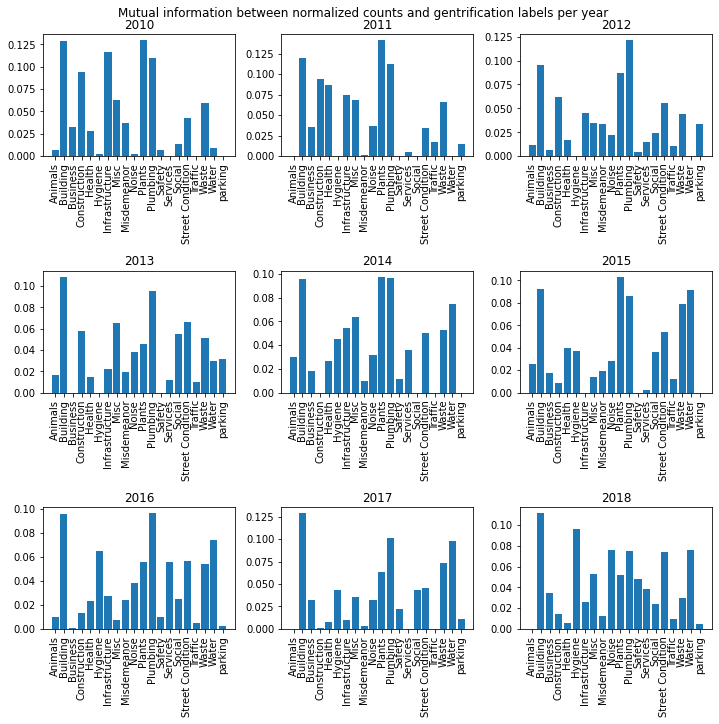

In [43]:
plt.figure(figsize=(10,10))

for idx, year in enumerate([2010,2011,2012,2013,2014,2015,2016,2017,2018]):

  plt.subplot(3,3,idx+1)
  feature_df = df_subset.loc[df['Year'] ==year]#.pivot_table(columns='Complaint Category', rows='GEOID')
  feature_df = feature_df.groupby(['GEOID', 'Complaint Category'])['normalized count'].sum().unstack(fill_value = 0)
  feature_df = feature_df.merge(labels, on='GEOID')

  target =  feature_df['Gentrification Status']
  features = feature_df[feature_df.columns[1:-1]]
  target_integers = target.astype('category').cat.codes

  mi = mutual_info_classif(features,target)

  plt.bar(x = features.columns, height=mi)
  plt.xticks(features.columns, features.columns, rotation='vertical')
  plt.title(year)

plt.tight_layout()

plt.suptitle('Mutual information between normalized counts and gentrification labels per year', y=1.001)
plt.show()

### Differences between years

In [44]:
feature_df = df_subset#.loc[df['Year'] ==2010]#.pivot_table(columns='Complaint Category', rows='GEOID')
feature_df = feature_df.groupby(['GEOID', 'Complaint Category', 'Year'])['normalized count'].sum().unstack(fill_value = 0)


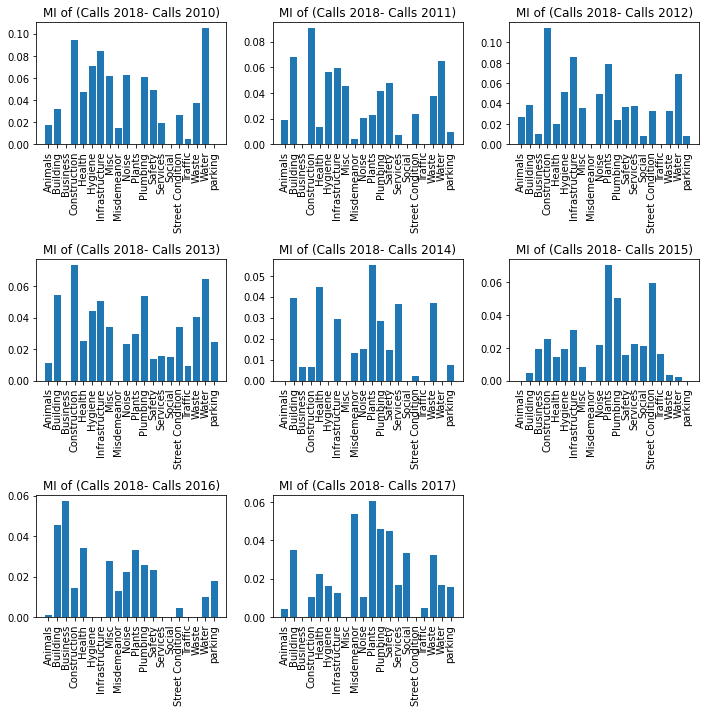

In [45]:
plt.figure(figsize=(10,10))

for idx, y1 in enumerate([2010,2011,2012,2013,2014,2015,2016,2017]):
  y2=2018
  #for y2 in [2010,2011,2012,2013,2014,2015,2016,2017,2018][idx+1:]:
  diff_df = feature_df[y2].unstack(fill_value=0) - feature_df[y1].unstack(fill_value=0)
  diff_df = diff_df.merge(labels, on='GEOID')
  target =  diff_df['Gentrification Status']
  features = diff_df[diff_df.columns[1:-1]]

  mi = mutual_info_classif(features,target)

  plt.subplot(3,3,idx+1)
  plt.bar(x = features.columns, height=mi)
  plt.xticks(features.columns, features.columns, rotation='vertical')
  plt.title(f'MI of (Calls {y2}- Calls {y1})')

plt.tight_layout()

plt.show()

### Try to predict

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import matthews_corrcoef, confusion_matrix

years = [2012,2013,2014,2015,2016,2017,2018]
test_mcc = []
train_mcc = []

for year in years:
  #prepare data
  feature_df = df_subset.loc[df['Year'] ==year]#.pivot_table(columns='Complaint Category', rows='GEOID')
  feature_df = feature_df.groupby(['GEOID', 'Complaint Category'])['normalized count'].sum().unstack(fill_value = 0)
  feature_df = feature_df.merge(labels, on='GEOID')
  target =  feature_df['Gentrification Status']
  features = feature_df[feature_df.columns[1:-1]]
  target_integers = target.astype('category').cat.codes

  #split and fit

  X_train, X_test, y_train, y_test = train_test_split(features, target_integers, test_size=0.2, random_state=42)

  cls = GradientBoostingClassifier(min_samples_leaf=5)
  cls.fit(X_train, y_train)

  #predict and report metrics
  preds = cls.predict(X_train)
  train_mcc.append(matthews_corrcoef(y_train, preds))

  preds=cls.predict(X_test)
  matrix = confusion_matrix(y_test, preds)
  test_mcc.append(matthews_corrcoef(y_test, preds))

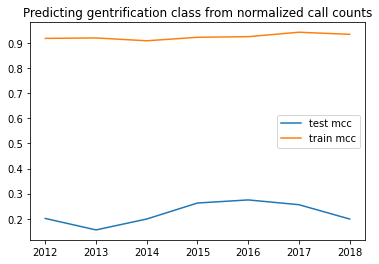

In [47]:
plt.title('Predicting gentrification class from normalized call counts')
plt.plot(years, test_mcc, label='test mcc')
plt.plot(years, train_mcc, label='train mcc')
plt.legend()

In [48]:
X_train, X_test, y_train, y_test = train_test_split(features, target_integers, test_size=0.2, random_state=42)

cls = GradientBoostingClassifier(min_samples_leaf=5)
cls.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=5, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [49]:
preds = cls.predict(X_train)
matthews_corrcoef(y_train, preds)

0.9340019294786611

In [50]:
preds=cls.predict(X_test)
matrix = confusion_matrix(y_test, preds)
matthews_corrcoef(y_test, preds)

0.19898991140488995

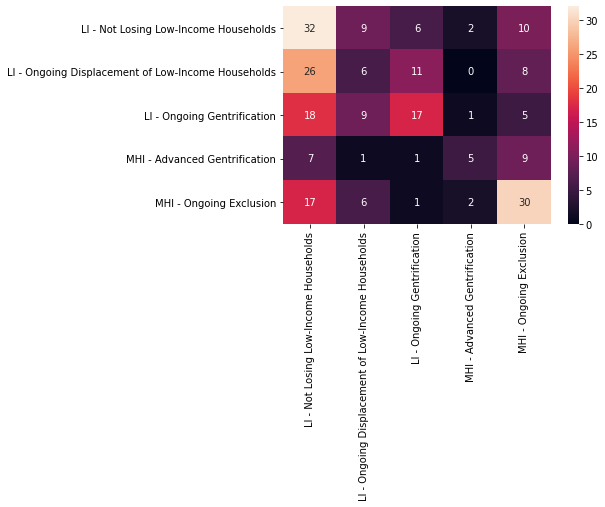

In [51]:
sns.heatmap(matrix, annot=True, xticklabels=target.astype('category').cat.categories, yticklabels=target.astype('category').cat.categories)

## Other labels

In [52]:
import pandas as pd
custom_labels = pd.read_csv('/content/drive/My Drive/citadel_hack/CitadelDatathon2020/data/2017_gentrified.csv')
custom_labels = custom_labels.rename({'gentrified':'Gentrification Status', 'geoid':'GEOID'},axis=1)
custom_labels['Gentrification Status'].unique()

array([0, 1])

In [53]:
#filter for eligibility
eligible= pd.read_csv('/content/drive/My Drive/citadel_hack/CitadelDatathon2020/data/eligible_tracts.csv')
eligible['Unnamed: 0'] = 'Eligible'
eligible = eligible.rename({'Unnamed: 0':'Eligibility', 'geoid':'GEOID'},axis=1)


In [54]:
eligible_df = df.merge(eligible, on='GEOID', how='inner')
eligible_df = eligible_df.drop('Eligibility', axis=1)

In [55]:
eligible_df = eligible_df.drop('Gentrification Status',axis=1)
eligible_df = eligible_df.merge(custom_labels, on='GEOID')
eligible_df

,GEOID,Year,Complaint Category,value,Population,normalized count,Gentrification Status
0,36005000200,2010,Animals,2.0,4542.0,0.000440,0
1,36005000200,2011,Animals,1.0,4542.0,0.000220,0
2,36005000200,2012,Animals,3.0,4542.0,0.000661,0
3,36005000200,2013,Animals,3.0,4542.0,0.000661,0
4,36005000200,2014,Animals,5.0,4542.0,0.001101,0
...,...,...,...,...,...,...,...
55552,36119002900,2018,Waste,1.0,3636.0,0.000275,0
55553,36119001502,2018,Plants,1.0,3133.0,0.000319,0
55554,36119001502,2013,Street Condition,1.0,3133.0,0.000319,0
55555,36119001502,2017,Street Condition,1.0,3133.0,0.000319,0


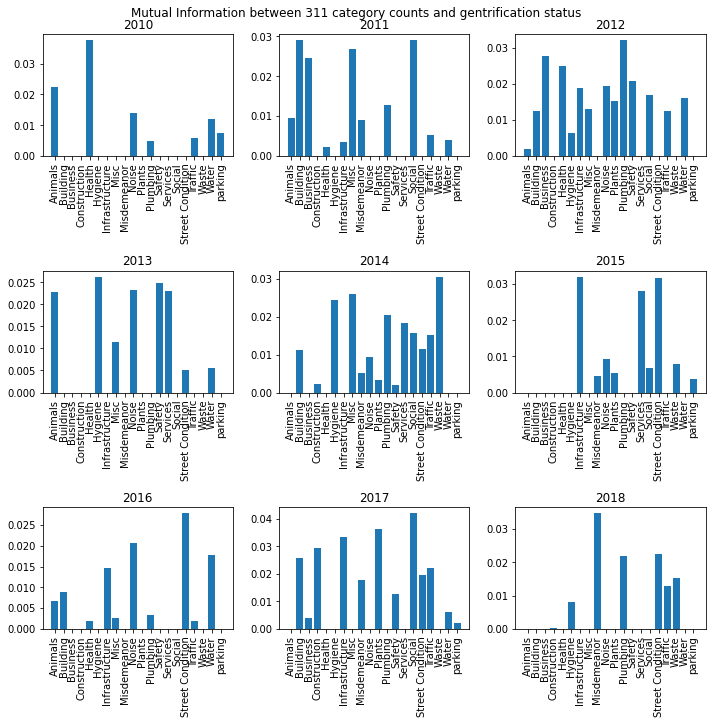

In [62]:
plt.figure(figsize=(10,10))

for idx, year in enumerate([2010,2011,2012,2013,2014,2015,2016,2017,2018]):

  plt.subplot(3,3,idx+1)
  feature_df = eligible_df.loc[eligible_df['Year'] ==year]#.pivot_table(columns='Complaint Category', rows='GEOID')
  feature_df = feature_df.groupby(['GEOID', 'Complaint Category'])['normalized count'].sum().unstack(fill_value = 0)
  feature_df = feature_df.merge(custom_labels, on='GEOID')

  target =  feature_df['Gentrification Status']
  features = feature_df[feature_df.columns[1:-1]]
  target_integers = target.astype('category').cat.codes

  mi = mutual_info_classif(features,target)

  plt.bar(x = features.columns, height=mi)
  plt.xticks(features.columns, features.columns, rotation='vertical')
  plt.title(year)

plt.tight_layout()

plt.suptitle('Mutual Information between 311 category counts and gentrification status', y=1.001)
plt.show()

In [46]:
feature_df = eligible_df#.loc[df['Year'] ==2010]#.pivot_table(columns='Complaint Category', rows='GEOID')
feature_df = feature_df.groupby(['GEOID', 'Complaint Category', 'Year'])['normalized count'].sum().unstack(fill_value = 0)

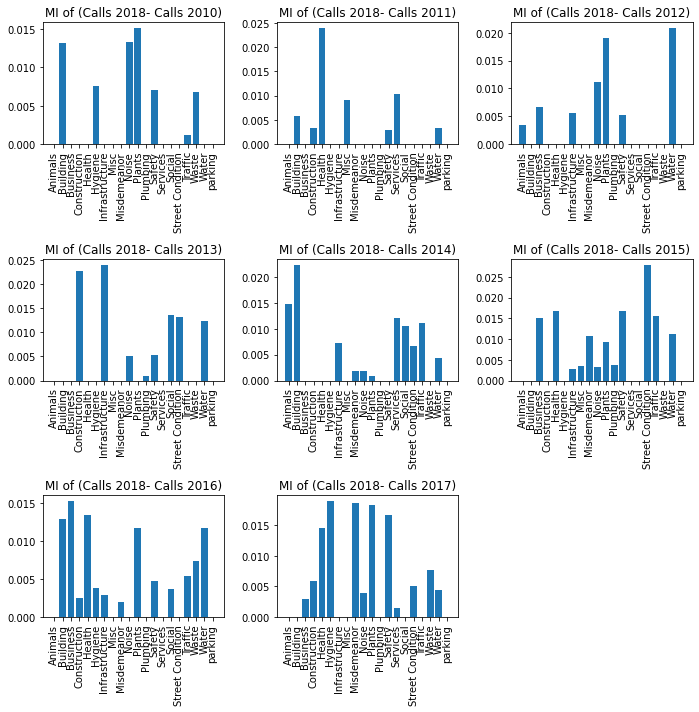

In [47]:
plt.figure(figsize=(10,10))

for idx, y1 in enumerate([2010,2011,2012,2013,2014,2015,2016,2017]):
  y2=2018
  #for y2 in [2010,2011,2012,2013,2014,2015,2016,2017,2018][idx+1:]:
  diff_df = feature_df[y2].unstack(fill_value=0) - feature_df[y1].unstack(fill_value=0)
  diff_df = diff_df.merge(custom_labels, on='GEOID')
  target =  diff_df['Gentrification Status']
  features = diff_df[diff_df.columns[1:-1]]

  mi = mutual_info_classif(features,target)

  plt.subplot(3,3,idx+1)
  plt.bar(x = features.columns, height=mi)
  plt.xticks(features.columns, features.columns, rotation='vertical')
  plt.title(f'MI of (Calls {y2}- Calls {y1})')

plt.tight_layout()

plt.show()

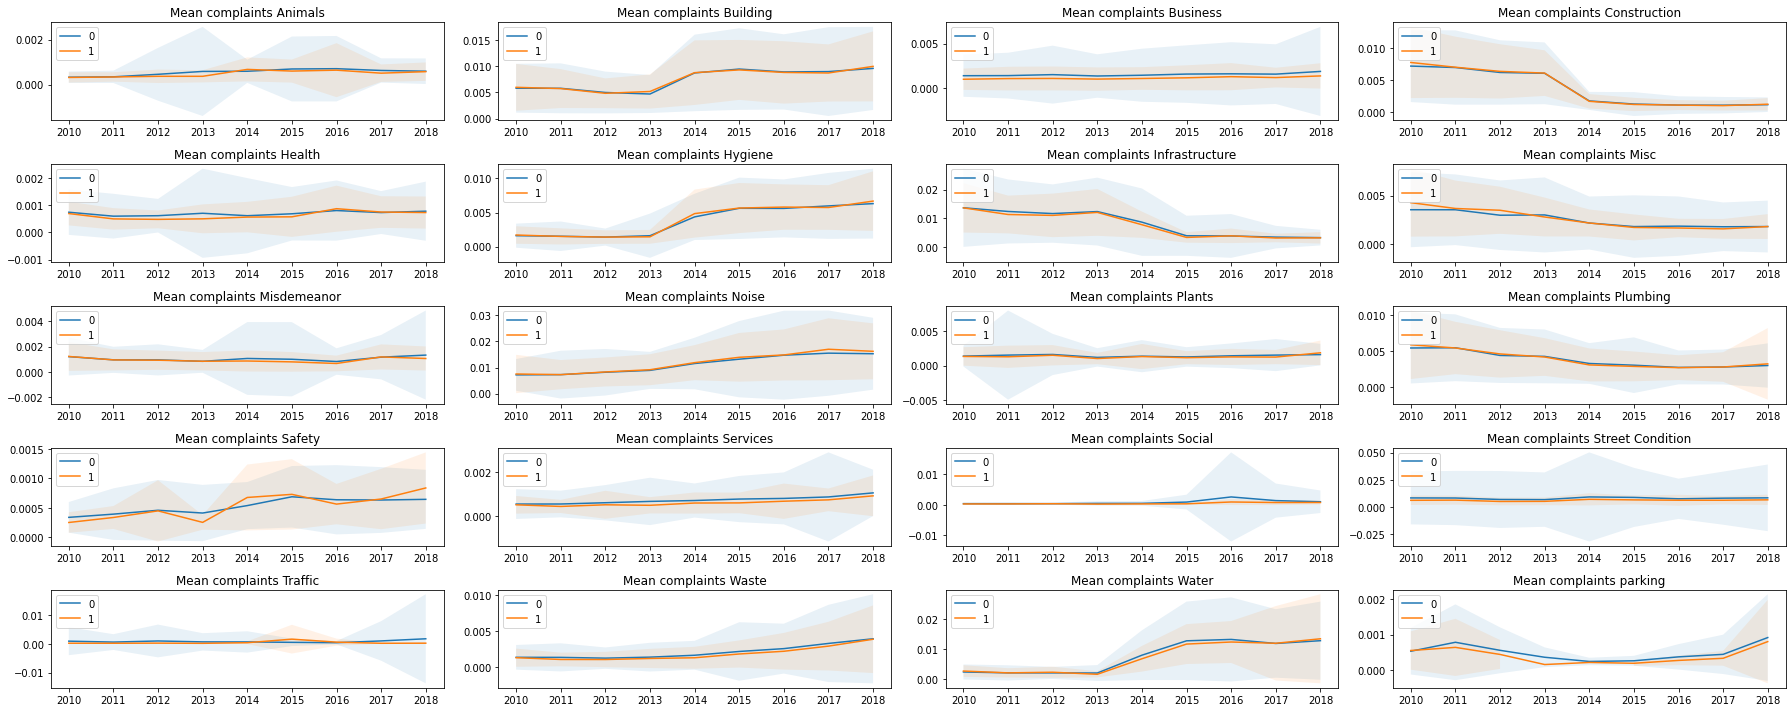

In [48]:
fig, axs = plt.subplots(5,4, figsize = (25,10))

for idx, category in enumerate(eligible_df['Complaint Category'].unique()):
  ax = axs.flat[idx]

  plot_df = eligible_df.loc[eligible_df['Complaint Category'] ==category]#[['GEOID', 'normalized count', 'Gentrification Status']]
  agg_df = plot_df.groupby(['Gentrification Status', 'Year'])['normalized count'].agg(minimum='min', maximum='max', mean='mean', std='std')

  mean = agg_df['mean'].unstack().T
  std =  agg_df['std'].unstack().T

  for cat in mean.columns:
      ax.plot(mean.index, mean[cat], label=cat)
      ax.fill_between(mean.index, mean[cat] - std[cat], mean[cat] + std[cat], alpha=0.1)

  ax.set_title(f'Mean complaints {category}')

  ax.legend(loc='upper left')

plt.tight_layout()

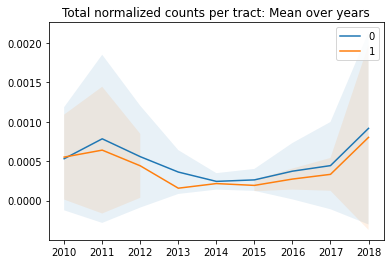

In [60]:
eligible_df.groupby(['Gentrification Status', 'Year'])['normalized count'].agg(minimum='min', maximum='max', mean='mean', std='std')
mean = agg_df['mean'].unstack().T
std =  agg_df['std'].unstack().T

for cat in [0,1]:
  plt.plot(mean.index, mean[cat], label=cat)
  plt.fill_between(mean.index, mean[cat] - std[cat], mean[cat] + std[cat], alpha=0.1)
  plt.legend()
  plt.title('Total normalized counts per tract: Mean over years')

47% of all counts per category/year are <=5:

In [85]:
(eligible_df['value']<=5).sum()/len(eligible_df)

0.46571671870564857

In [146]:
pivoted = eligible_df.pivot_table(index=['Gentrification Status','GEOID', 'Year'],values='value', aggfunc=sum).unstack(fill_value=0)
pivoted = pivoted.reset_index()
pivoted

Gentrification Status        GEOID  value  ...                     
Year                                      2010  ...   2016   2017   2018
0                        0  36005000100    1.0  ...    5.0    6.0    9.0
1                        0  36005001600  191.0  ...  221.0  224.0  215.0
2                        0  36005001900  299.0  ...  456.0  441.0  502.0
3                        0  36005002000  203.0  ...  296.0  269.0  352.0
4                        0  36005002300   46.0  ...  130.0   62.0   61.0
..                     ...          ...    ...  ...    ...    ...    ...
649                      1  36081055900   97.0  ...  111.0   96.0  110.0
650                      1  36081064101   30.0  ...   26.0   29.0   38.0
651                      1  36081122702  186.0  ...  233.0  235.0  306.0
652                      1  36085000700  256.0  ...  274.0  245.0  282.0
653                      1  36085001100  268.0  ...  348.0  270.0  353.0

[654 rows x 11 columns]

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3884: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Text(0.5, 1.0, 'After mean subtraction per tract')

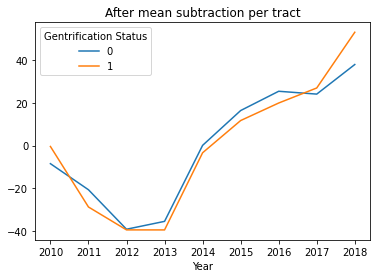

In [147]:
#center

pivoted['value'] = pivoted['value'].sub(pivoted['value'].mean(axis=1), axis=0)

pivoted.groupby('Gentrification Status').mean()['value'].T.plot()
plt.title('After mean subtraction per tract')

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3884: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Text(0.5, 1.0, 'After mean subtraction and population normalization per tract')

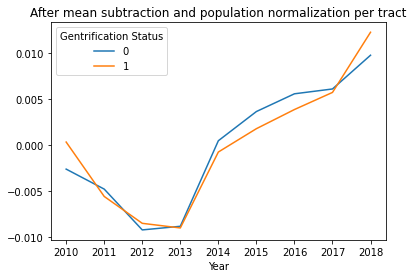

In [148]:
population_vals = pivoted.merge(census_df, on='GEOID')['Population']
pivoted['value'] = pivoted['value'].div(population_vals, axis=0)

pivoted.groupby('Gentrification Status').mean()['value'].T.plot()
plt.title('After mean subtraction and population normalization per tract')

In [149]:
pivoted['value'] = pivoted['value'].diff(axis=1)
pivoted = pivoted.drop(('value',2010), axis=1)

Gentrification Status        GEOID value  ...                              
Year                                     2010  ...      2016      2017      2018
0                        0  36005000100   NaN  ...  0.000565  0.000141  0.000424
1                        0  36005001600   NaN  ...  0.004901  0.000507 -0.001521
2                        0  36005001900   NaN  ...  0.015552 -0.005425  0.022061
3                        0  36005002000   NaN  ...  0.002338 -0.002870  0.008821
4                        0  36005002300   NaN  ...  0.011304 -0.014783 -0.000217
..                     ...          ...   ...  ...       ...       ...       ...
649                      1  36081055900   NaN  ...  0.012579 -0.013477  0.012579
650                      1  36081064101   NaN  ... -0.000447  0.001340  0.004020
651                      1  36081122702   NaN  ...  0.001193  0.000265  0.009408
652                      1  36085000700   NaN  ...  0.003088 -0.005596  0.007140
653                      1  36085001100   NaN  ...  0.022340 -0.022928  0.024397

[654 rows x 11 columns]

In [205]:
means

Gentrification Status,0,1
Year,,
2011,0.000176,0.000044
2012,0.000075,-0.000081
2013,0.000661,0.000766
2014,-0.000024,0.000020
2015,-0.000375,-0.000355
2016,0.000068,0.000101
2017,-0.000351,-0.000347
2018,-0.000073,-0.000007


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3884: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


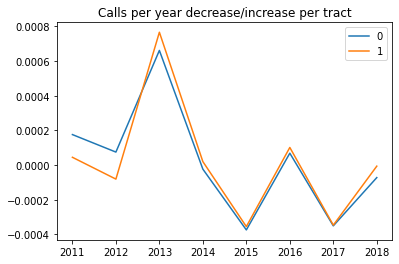

In [206]:
means = pivoted.groupby('Gentrification Status').mean()['value'].T
stds = pivoted.groupby('Gentrification Status').std()['value'].T
#plt.title('Increase/Decrease 311 calls YoY')
for cat in [0,1]:
  plt.plot(means.index, means[cat], label=cat)
  #plt.fill_between(means.index, means[cat] - stds[cat], means[cat] + stds[cat], alpha=0.1)
  plt.legend()
  plt.title('Calls per year decrease/increase per tract')

### Test normalizations and differencing on all categories

In [174]:
means = pd.DataFrame(eligible_df.groupby(['GEOID', 'Complaint Category'])['value'].sum()).reset_index().rename({'value':'mean'},axis=1)
eligible_df['value'] = eligible_df['value'] - eligible_df.merge(means, on=['GEOID', 'Complaint Category'])['mean']

In [179]:
eligible_df['normalized count'] = eligible_df['value']/eligible_df['Population']

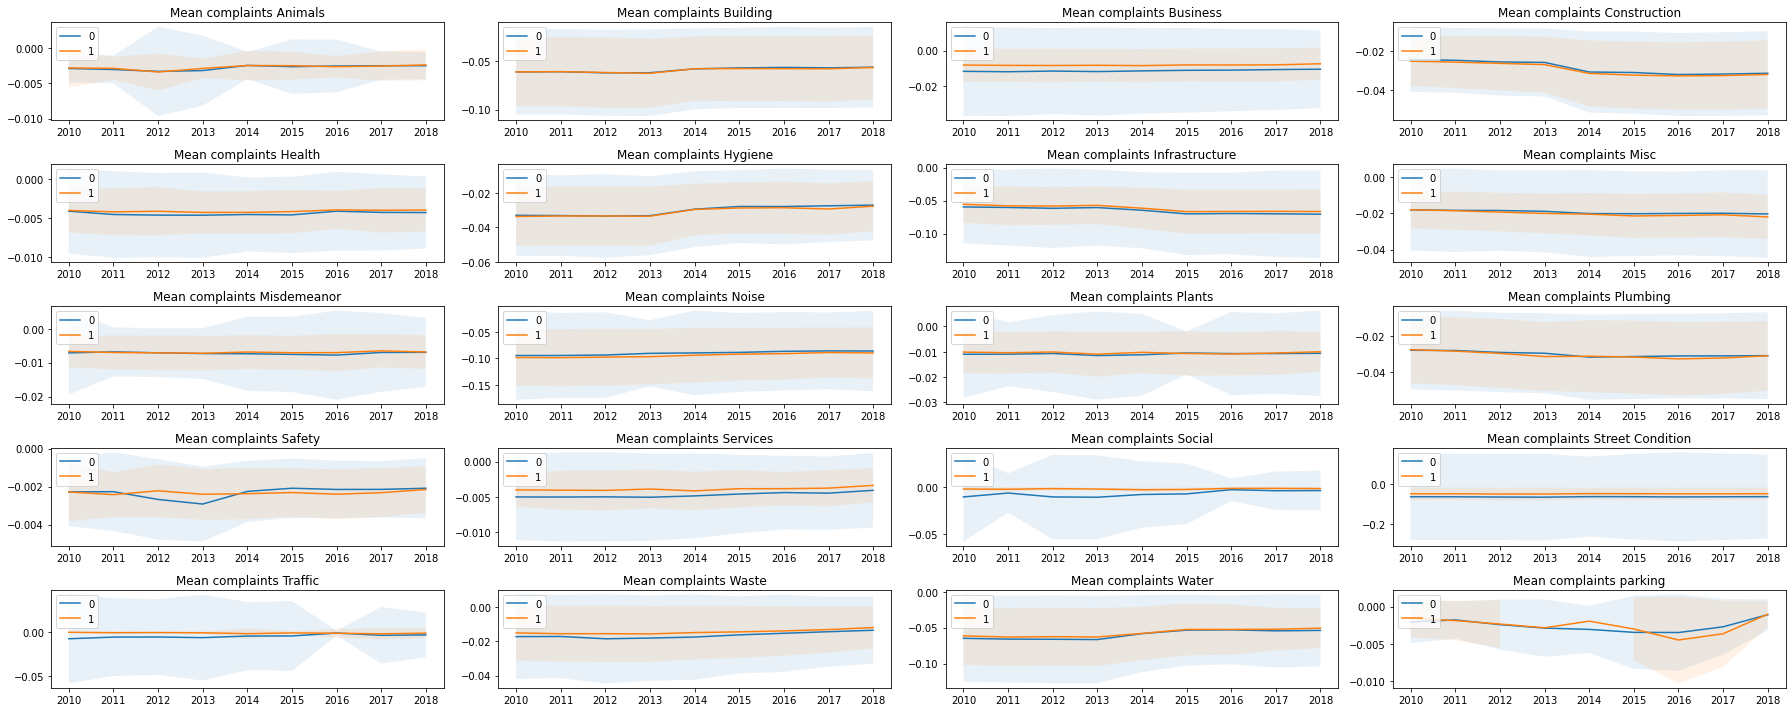

In [207]:
fig, axs = plt.subplots(5,4, figsize = (25,10))

for idx, category in enumerate(eligible_df['Complaint Category'].unique()):
  ax = axs.flat[idx]

  plot_df = eligible_df.loc[eligible_df['Complaint Category'] ==category]#[['GEOID', 'normalized count', 'Gentrification Status']]
  agg_df = plot_df.groupby(['Gentrification Status', 'Year'])['normalized count'].agg(minimum='min', maximum='max', mean='mean', std='std')

  mean = agg_df['mean'].unstack().T
  std =  agg_df['std'].unstack().T

  for cat in mean.columns:
      ax.plot(mean.index, mean[cat], label=cat)
      ax.fill_between(mean.index, mean[cat] - std[cat], mean[cat] + std[cat], alpha=0.1)

  ax.set_title(f'Mean complaints {category}')

  ax.legend(loc='upper left')

plt.tight_layout()

In [210]:
fig, axs = plt.subplots(5,4, figsize = (25,10))

for idx, category in enumerate(eligible_df['Complaint Category'].unique()):
  ax = axs.flat[idx]

  plot_df = eligible_df.loc[eligible_df['Complaint Category'] ==category]#[['GEOID', 'normalized count', 'Gentrification Status']]
  #plot_df.reset_index(drop=True)
  pivoted = input_df.pivot_table(index=['Gentrification Status','GEOID', 'Year'],values='value', aggfunc=sum).unstack(fill_value=0)
  pivoted = pivoted.reset_index()
  pivoted['value'] = pivoted['value'].sub(pivoted['value'].mean(axis=1), axis=0)
  population_vals = pivoted.merge(census_df, on='GEOID')['Population']

  pivoted['value'] = pivoted['value'].div(population_vals, axis=0)
  pivoted['value'] = pivoted['value'].diff(axis=1)
  pivoted = pivoted.drop(('value',2010), axis=1)

  means = pivoted.groupby('Gentrification Status').mean()['value'].T
  stds = pivoted.groupby('Gentrification Status').std()['value'].T

  for cat in mean.columns:
      ax.plot(mean.index, mean[cat], label=cat)
      ax.fill_between(mean.index, mean[cat] - std[cat], mean[cat] + std[cat], alpha=0.1)

  ax.set_title(f'Mean change complaints {category}')

  ax.legend(loc='upper left')

plt.tight_layout()

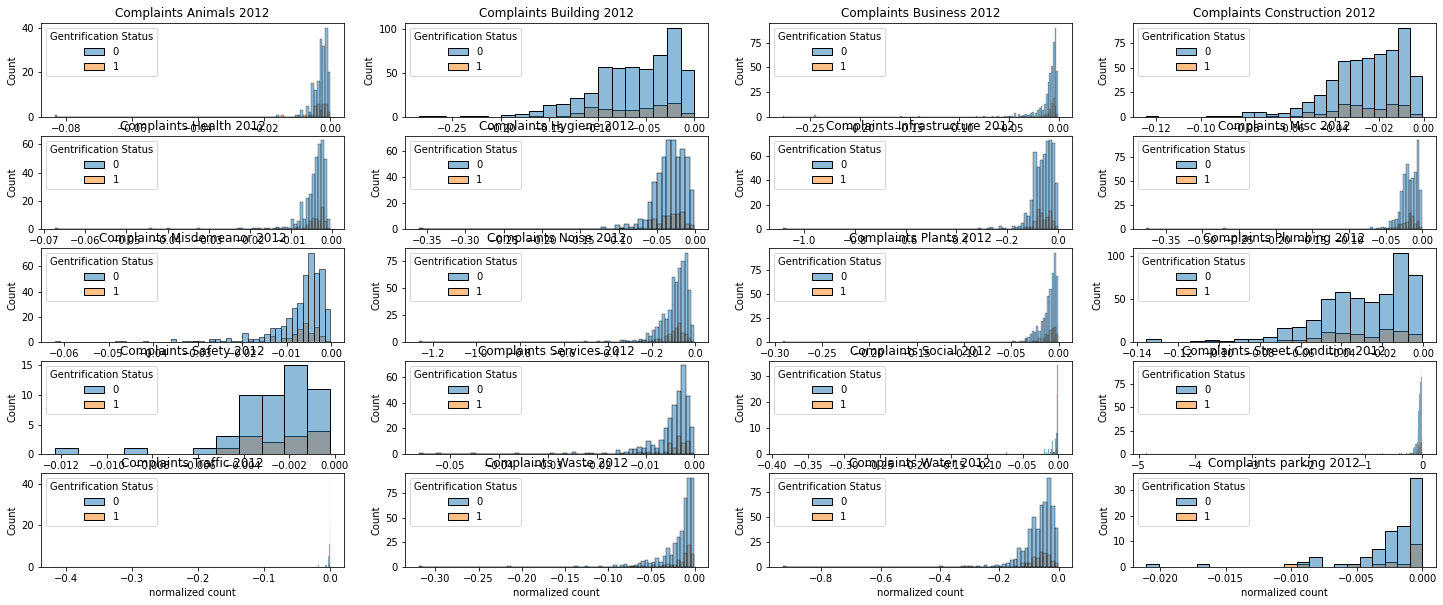

In [229]:
fig, axs = plt.subplots(5,4, figsize = (25,10))

for idx, category in enumerate(eligible_df['Complaint Category'].unique()):
  ax = axs.flat[idx]
  ax.set_title(f'Complaints {category}')

  plot_df = eligible_df.loc[eligible_df['Complaint Category'] ==category]

  sns.histplot(plot_df, x='normalized count', hue='Gentrification Status', ax=ax)

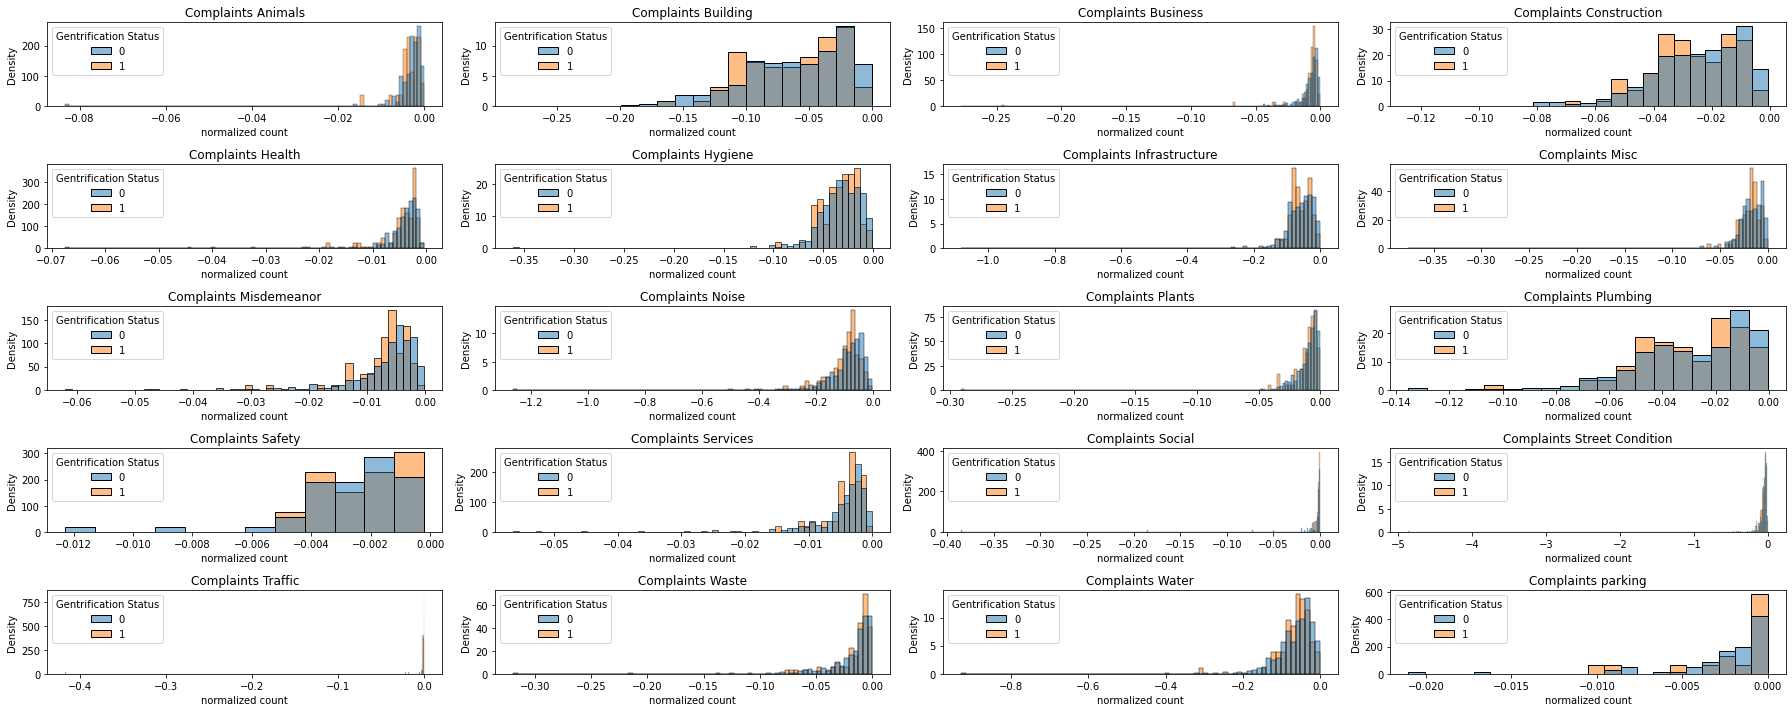

In [231]:
year=2012
fig, axs = plt.subplots(5,4, figsize = (25,10))

for idx, category in enumerate(eligible_df['Complaint Category'].unique()):
  ax = axs.flat[idx]
  ax.set_title(f'Complaints {category}')

  plot_df = eligible_df.loc[(eligible_df['Complaint Category'] ==category) & (eligible_df['Year']==year)]

  sns.histplot(plot_df, x='normalized count', hue='Gentrification Status', ax=ax, stat='density', common_bins=True, common_norm=False)

  plt.tight_layout()

In [256]:
eligible_df.pivot_table(values='value',index='GEOID', columns=['Complaint Category', 'Year'])

Complaint Category Animals                          ... parking                    
Year                  2010  2011  2012  2013  2014  ...    2014 2015 2016 2017 2018
GEOID                                               ...                            
36005000100            NaN   NaN   NaN   NaN   NaN  ...     NaN  NaN  NaN  NaN  NaN
36005001600            NaN   NaN   NaN   NaN  -7.0  ...     NaN  NaN  NaN  NaN  NaN
36005001900            NaN -15.0 -15.0   NaN -13.0  ...     NaN  NaN  NaN  NaN  NaN
36005002000            NaN -28.0 -26.0 -23.0 -26.0  ...     NaN  NaN  NaN  NaN  NaN
36005002300            NaN   NaN   NaN   NaN   NaN  ...     NaN  NaN  NaN  NaN  NaN
...                    ...   ...   ...   ...   ...  ...     ...  ...  ...  ...  ...
36085031901          -11.0   NaN   NaN -10.0   NaN  ...     NaN  NaN  NaN  NaN  NaN
36085031902          -20.0 -21.0   NaN   NaN -20.0  ...     NaN  NaN  NaN  NaN  NaN
36085032300          -13.0 -13.0   NaN   NaN -13.0  ...     NaN  NaN  NaN  NaN  NaN
36119000203            NaN   NaN   NaN   NaN   NaN  ...     NaN  NaN  NaN  NaN  NaN
36119002900            NaN   NaN   NaN   NaN   NaN  ...     NaN  NaN  NaN  NaN  NaN

[654 rows x 180 columns]

In [280]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

All years as features

In [331]:
pivoted = eligible_df.pivot_table(index=['Gentrification Status','GEOID', 'Complaint Category', 'Year'],values='value', aggfunc=sum).unstack(fill_value=0).unstack(fill_value=0)
pivoted = pivoted.reset_index()
#pivoted['value'] = pivoted['value'].sub(pivoted['value'].mean(axis=1), axis=0)
#population_vals = pivoted.merge(census_df, on='GEOID')['Population']

 # pivoted['value'] = pivoted['value'].div(population_vals, axis=0)
X=pivoted['value'].values
proj = TSNE()
red = proj.fit_transform(X)
sns.scatterplot(x=red[:,0],y=red[:,1], hue=pivoted['Gentrification Status'])

Complaint Category,Animals,Building,Business,Construction,Health,Hygiene,Infrastructure,Misc,Misdemeanor,Noise,Plants,Plumbing,Safety,Services,Social,Street Condition,Traffic,Waste,Water,parking
Year,,,,,,,,,,,,,,,,,,,,
2010,-2919.0,-177970.0,-21388.0,-68432.0,-9688.0,-86508.0,-167195.0,-48495.0,-14342.0,-284895.0,-21696.0,-79042.0,-1191.0,-8227.0,-2114.0,-127937.0,-525.0,-32340.0,-182385.0,-1261.0
2011,-3123.0,-178037.0,-21475.0,-69624.0,-9194.0,-86169.0,-171186.0,-48941.0,-14779.0,-285690.0,-21758.0,-79178.0,-846.0,-8240.0,-2156.0,-127932.0,-635.0,-32475.0,-183392.0,-1047.0
2012,-2853.0,-180680.0,-21297.0,-71881.0,-8879.0,-86713.0,-172404.0,-49974.0,-14580.0,-282664.0,-21609.0,-82207.0,-682.0,-8093.0,-2553.0,-131576.0,-551.0,-31535.0,-184159.0,-967.0
2013,-3389.0,-180894.0,-21496.0,-72107.0,-8872.0,-85785.0,-170403.0,-50597.0,-14614.0,-279551.0,-21845.0,-82555.0,-1150.0,-8522.0,-2657.0,-131593.0,-506.0,-32010.0,-183856.0,-70.0
2014,-5058.0,-169692.0,-21575.0,-83342.0,-9042.0,-79194.0,-182583.0,-52034.0,-14686.0,-271340.0,-21714.0,-85326.0,-4151.0,-8563.0,-3797.0,-127702.0,-830.0,-31905.0,-170294.0,-96.0
2015,-5069.0,-167140.0,-21093.0,-80244.0,-9203.0,-75489.0,-196560.0,-53263.0,-14795.0,-266988.0,-21897.0,-86145.0,-4090.0,-8677.0,-4321.0,-127008.0,-746.0,-31347.0,-155743.0,-608.0
2016,-5202.0,-168472.0,-21338.0,-79791.0,-9344.0,-75532.0,-196513.0,-53081.0,-14267.0,-262422.0,-21749.0,-86358.0,-4243.0,-8901.0,-3668.0,-129086.0,-859.0,-30767.0,-154319.0,-465.0
2017,-5054.0,-169026.0,-21637.0,-79224.0,-9365.0,-74987.0,-196672.0,-53430.0,-14757.0,-259814.0,-21606.0,-86310.0,-4234.0,-8821.0,-4630.0,-128450.0,-962.0,-29622.0,-157998.0,-902.0
2018,-5185.0,-167202.0,-21104.0,-81363.0,-9385.0,-74074.0,-197469.0,-52971.0,-14526.0,-259325.0,-21316.0,-86069.0,-4232.0,-8779.0,-4834.0,-128184.0,-887.0,-28310.0,-155739.0,-1050.0


/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


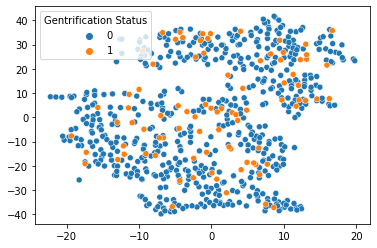

In [338]:
pivoted = eligible_df.pivot_table(index=['Gentrification Status','GEOID', 'Complaint Category'],values='value', aggfunc=sum).unstack(fill_value=0)
pivoted = pivoted.reset_index()
population_vals = pivoted.merge(census_df, on='GEOID')['Population']

pivoted['value'] = pivoted['value'].div(population_vals, axis=0)

X=pivoted['value'].values
proj = TSNE()
red = proj.fit_transform(X)
sns.scatterplot(x=red[:,0],y=red[:,1], hue=pivoted['Gentrification Status'])

In [288]:
eligible_df['Year'].unique().shape

(9,)

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different leve

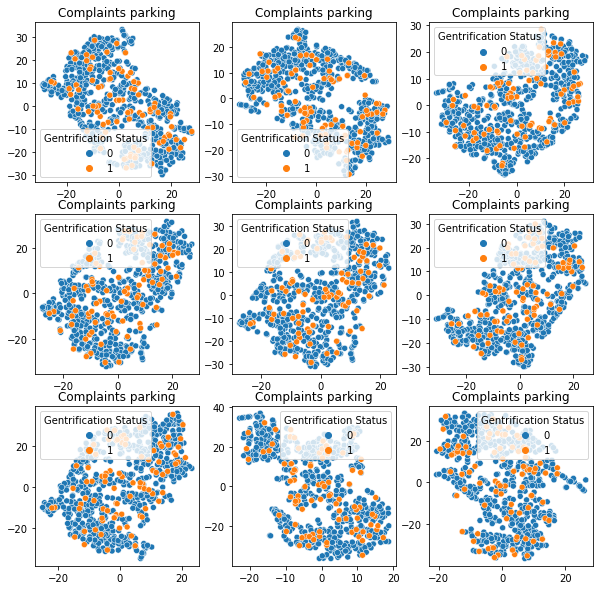

In [289]:
fig, axs = plt.subplots(3,3, figsize = (10,10))

for idx, year in enumerate(eligible_df['Year'].unique()):
  ax = axs.flat[idx]
  ax.set_title(f'Complaints {category}')

  pivoted = eligible_df.loc[eligible_df['Year'] ==year].pivot_table(index=['Gentrification Status','GEOID', 'Complaint Category'],values='value', aggfunc=sum).unstack(fill_value=0)
  pivoted = pivoted.reset_index()
  pivoted['value'] = pivoted['value'].sub(pivoted['value'].mean(axis=1), axis=0)
  population_vals = pivoted.merge(census_df, on='GEOID')['Population']
  pivoted['value'] = pivoted['value'].div(population_vals, axis=0)

  X=pivoted['value'].values
  proj = TSNE()
  red = proj.fit_transform(X)
  sns.scatterplot(x=red[:,0],y=red[:,1], hue=pivoted['Gentrification Status'], ax=ax)

# Recreate logistic regression


In [248]:
X = pd.read_csv('/content/drive/My Drive/citadel_hack/CitadelDatathon2020/data/features.csv')


from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.metrics import classification_report, roc_auc_score, plot_roc_curve
from sklearn.preprocessing import StandardScaler

X_train, X_val, y_train, y_val = train_test_split(X.iloc[:,:-1], X.iloc[:,-1], test_size=0.1, random_state=42)
scaler = StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_val=scaler.transform(X_val)

clf = LogisticRegression(random_state=42,C=74,class_weight='balanced').fit(X_train,y_train)
print(classification_report(y_train,clf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.96      0.71      0.82       817
           1       0.27      0.79      0.40       110

    accuracy                           0.72       927
   macro avg       0.61      0.75      0.61       927
weighted avg       0.88      0.72      0.77       927



#### Compute improvement over random

In [244]:
roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])/(y_train.sum()/len(y_train))

6.775482262257604

In [245]:
roc_auc_score(y_val, clf.predict_proba(X_val)[:,1])/(y_val.sum()/len(y_val))

7.661157024793388

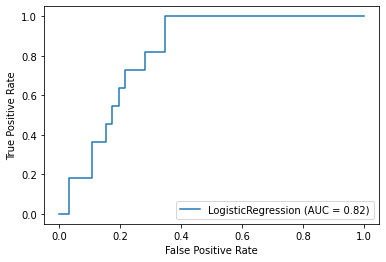

In [253]:
plot_roc_curve(clf, X_val, y_val)

### Legacy Initial exploration of 311 df

- most complaint types only one incidence
- many different types, might need additional grouping

In [ ]:
pd.DataFrame(df_with_tract.groupby(['Complaint Type'])['Unique Key'].count())

,Unique Key
Complaint Type,
APPLIANCE,3418
Adopt-A-Basket,10
Advocate - Lien,4
Advocate-Commercial Exemptions,1
Advocate-Personal Exemptions,1
...,...
Water Quality,431
Water System,17583
Window Guard,5


Text(0.5, 1.0, "Don't really find clusters this way")

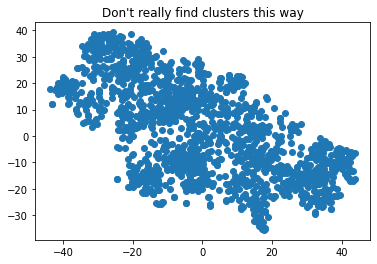

In [ ]:
feature_df = pd.crosstab(df_with_tract['TRACTCE'], df_with_tract['Complaint Type'], normalize='index')#, margins=True, margins_name="Total")

#remove low frequency categories
#TODO work on this filtering criterion, 1% precedence on average is a arbitrary choice
feature_df = feature_df[feature_df.columns[feature_df.sum(axis=0) >0.001*(len(feature_df))]]


#TODO normalize by population - get from Census df
from sklearn.manifold import TSNE

tsne = TSNE()
reduced = tsne.fit_transform(feature_df)
plt.scatter(reduced[:,0], reduced[:,1])
plt.title("Don't really find clusters this way")

Text(0.5, 1.0, 'Wonder what the linearity is.')

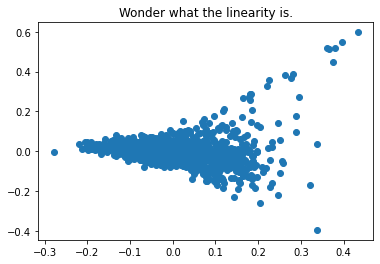

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
reduced = pca.fit_transform(feature_df)
plt.scatter(reduced[:,0], reduced[:,1])
plt.title("Wonder what the linearity is.")

Text(0.5, 1.0, 'Cumulative explained variance')

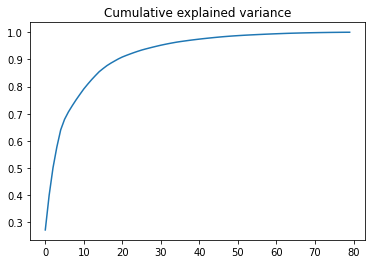

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative explained variance')

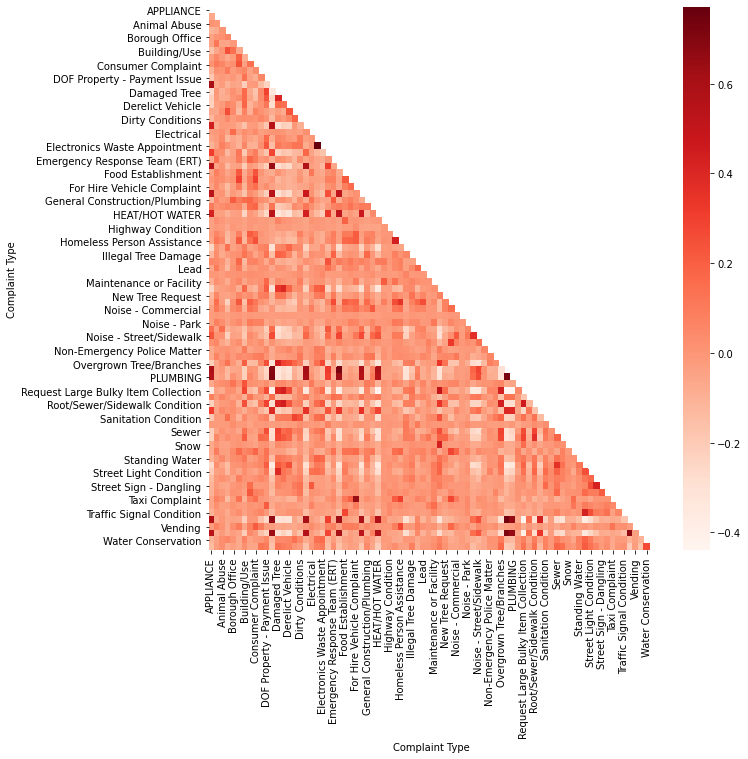

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,10))
cor = feature_df.corr()

mask = np.zeros_like(cor)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(cor, annot=False, mask=mask, cmap=plt.cm.Reds)

In [ ]:
feature_df

Complaint Type,APPLIANCE,Air Quality,Animal Abuse,Blocked Driveway,Borough Office,Broken Parking Meter,Building/Use,Construction Safety Enforcement,Consumer Complaint,Curb Condition,DOF Property - Payment Issue,DOOR/WINDOW,Damaged Tree,Dead/Dying Tree,Derelict Vehicle,Derelict Vehicles,Dirty Conditions,ELECTRIC,Electrical,Electronics Waste,Electronics Waste Appointment,Elevator,Emergency Response Team (ERT),FLOORING/STAIRS,Food Establishment,Food Poisoning,For Hire Vehicle Complaint,GENERAL,General Construction/Plumbing,Graffiti,HEAT/HOT WATER,Hazardous Materials,Highway Condition,Homeless Encampment,Homeless Person Assistance,Illegal Parking,Illegal Tree Damage,Indoor Air Quality,Lead,Litter Basket / Request,Maintenance or Facility,Missed Collection (All Materials),New Tree Request,Noise,Noise - Commercial,Noise - Helicopter,Noise - Park,Noise - Residential,Noise - Street/Sidewalk,Noise - Vehicle,Non-Emergency Police Matter,Other Enforcement,Overgrown Tree/Branches,PAINT/PLASTER,PLUMBING,Plumbing,Request Large Bulky Item Collection,Rodent,Root/Sewer/Sidewalk Condition,SAFETY,Sanitation Condition,School Maintenance,Sewer,Sidewalk Condition,Snow,Special Projects Inspection Team (SPIT),Standing Water,Street Condition,Street Light Condition,Street Sign - Damaged,Street Sign - Dangling,Street Sign - Missing,Taxi Complaint,Traffic,Traffic Signal Condition,UNSANITARY CONDITION,Vending,WATER LEAK,Water Conservation,Water System
TRACTCE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000100,0.000000,0.017192,0.000000,0.030086,0.000000,0.018625,0.004298,0.005731,0.010029,0.001433,0.004298,0.001433,0.012894,0.002865,0.010029,0.010029,0.005731,0.000000,0.001433,0.002865,0.000000,0.005731,0.000000,0.001433,0.007163,0.001433,0.007163,0.000000,0.020057,0.002865,0.008596,0.001433,0.001433,0.000000,0.004298,0.203438,0.0,0.007163,0.008596,0.001433,0.005731,0.007163,0.007163,0.048711,0.058739,0.004298,0.004298,0.047278,0.041547,0.034384,0.000000,0.005731,0.000000,0.001433,0.000000,0.001433,0.020057,0.008596,0.000000,0.000000,0.015759,0.002865,0.014327,0.007163,0.004298,0.001433,0.000000,0.057307,0.041547,0.011461,0.002865,0.014327,0.014327,0.002865,0.021490,0.004298,0.008596,0.001433,0.000000,0.028653
000200,0.003009,0.000000,0.002006,0.096289,0.003009,0.000000,0.027081,0.001003,0.004012,0.007021,0.000000,0.007021,0.014042,0.000000,0.047141,0.057172,0.019057,0.016048,0.000000,0.000000,0.004012,0.001003,0.002006,0.007021,0.002006,0.000000,0.001003,0.008024,0.014042,0.007021,0.037111,0.000000,0.000000,0.001003,0.001003,0.113340,0.0,0.000000,0.002006,0.000000,0.000000,0.015045,0.004012,0.001003,0.003009,0.000000,0.002006,0.072217,0.027081,0.022066,0.001003,0.002006,0.005015,0.011033,0.009027,0.002006,0.064193,0.017051,0.003009,0.003009,0.013039,0.000000,0.008024,0.013039,0.002006,0.001003,0.000000,0.043129,0.032096,0.004012,0.002006,0.003009,0.001003,0.000000,0.030090,0.019057,0.000000,0.005015,0.008024,0.038114
000201,0.000000,0.020619,0.000000,0.010309,0.000000,0.000000,0.000000,0.000000,0.010309,0.000000,0.000000,0.010309,0.000000,0.000000,0.010309,0.000000,0.000000,0.010309,0.000000,0.000000,0.000000,0.000000,0.010309,0.010309,0.000000,0.000000,0.000000,0.000000,0.000000,0.030928,0.113402,0.010309,0.000000,0.000000,0.010309,0.041237,0.0,0.000000,0.010309,0.000000,0.000000,0.000000,0.000000,0.041237,0.010309,0.000000,0.000000,0.175258,0.010309,0.010309,0.000000,0.000000,0.000000,0.010309,0.020619,0.000000,0.030928,0.030928,0.000000,0.010309,0.000000,0.000000,0.000000,0.010309,0.000000,0.000000,0.010309,0.010309,0.020619,0.000000,0.000000,0.010309,0.010309,0.000000,0.000000,0.020619,0.000000,0.010309,0.000000,0.103093
000202,0.000000,0.000000,0.013043,0.000000,0.000000,0.000000,0.008696,0.000000,0.004348,0.000000,0.000000,0.008696,0.004348,0.000000,0.004348,0.000000,0.013043,0.000000,0.004348,0.000000,0.000000,0.004348,0.000000,0.000000,0.000000,0.000000,0.008696,0.000000,0.000000,0.008696,0.060870,0.004348,0.0043